# EDA of the dataset

In [28]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple, Set
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from src.utils.logger import get_logger


In [7]:
# Configure logger
logger = get_logger(__name__)

# Set style for better visualization
sns.set_theme()


# Load the data

In [8]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load the trials data from CSV file"""
    try:
        logger.info(f"Loading data from {file_path}")
        df = pd.read_csv(file_path)
        logger.info(f"Successfully loaded {len(df)} records")
        return df
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

# Load data
file_path = Path('../data/trials.csv')
df = load_data(str(file_path))


{"timestamp": "2025-02-20T07:42:13.862637", "level": "INFO", "name": "__main__", "module": "213583333", "function": "load_data", "line": 12, "message": "Loading data from ../data/trials.csv", "taskName": "Task-4"}
{"timestamp": "2025-02-20T07:42:13.906604", "level": "INFO", "name": "__main__", "module": "213583333", "function": "load_data", "line": 14, "message": "Successfully loaded 1759 records", "taskName": "Task-4"}


## Text length analysis

In [4]:
def analyze_text_length(df: pd.DataFrame) -> dict:
    """Analyze text length statistics for each class"""
    # Calculate text length for each description
    df['text_length'] = df['description'].str.len()
    
    # Calculate statistics per class
    stats = df.groupby('label')['text_length'].agg([
        'count',
        'mean',
        'std',
        'min',
        'max',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75)
    ]).round(2)
    
    stats.columns = ['Count', 'Mean', 'Std', 'Min', 'Max', 'Q1', 'Q3']
    return stats

def plot_length_distribution(df: pd.DataFrame, save_path: str = None):
    """Create visualizations for text length distribution"""
    # Calculate text lengths
    df['text_length'] = df['description'].str.len()
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Boxplot
    sns.boxplot(x='label', y='text_length', data=df, ax=ax1)
    ax1.set_title('Text Length Distribution by Class (Boxplot)')
    ax1.set_xlabel('Disease Class')
    ax1.set_ylabel('Text Length (characters)')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot with individual points
    sns.violinplot(x='label', y='text_length', data=df, ax=ax2)
    ax2.set_title('Text Length Distribution by Class (Violin Plot)')
    ax2.set_xlabel('Disease Class')
    ax2.set_ylabel('Text Length (characters)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")



{"timestamp": "2025-02-19T16:05:52.049618", "level": "INFO", "name": "__main__", "module": "1777717845", "function": "<module>", "line": 3, "message": "\nText length statistics per class:", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:05:52.052066", "level": "INFO", "name": "__main__", "module": "1777717845", "function": "<module>", "line": 4, "message": "\n                               Count     Mean      Std  Min    Max      Q1  \\\nlabel                                                                        \nALS                              368  1723.85  1720.49   38  13400  711.25   \nDementia                         368  2414.52  2433.44   73  14976  899.50   \nObsessive Compulsive Disorder    358  2212.34  2437.94    9  21765  853.75   \nParkinson\u2019s Disease              330  1740.59  1762.82   24  11737  618.00   \nScoliosis                        335  1963.01  1929.05    9  11880  743.50   \n\n                                    Q3  \nlabel                          

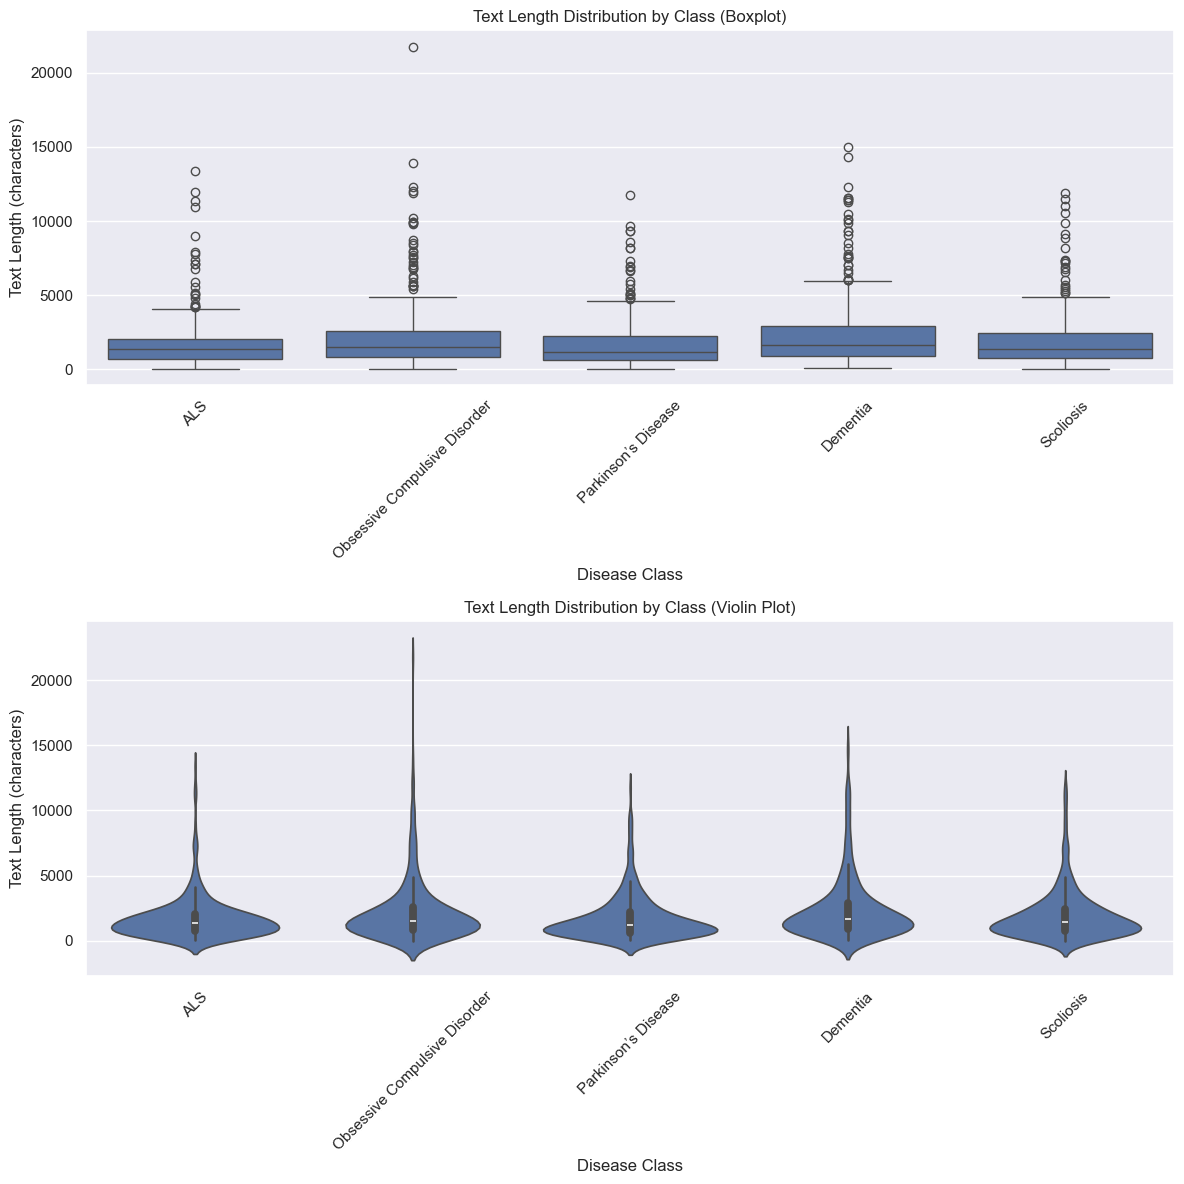

In [5]:
# Calculate statistics
stats = analyze_text_length(df)
logger.info("\nText length statistics per class:")
logger.info("\n" + str(stats))

# Create plots
plot_path = Path('figures/text_length_distribution.png')
plot_path.parent.mkdir(exist_ok=True)
plot_length_distribution(df, str(plot_path))

# Additional insights
total_mean = df['text_length'].mean()
total_std = df['text_length'].std()
logger.info(f"\nOverall statistics:")
logger.info(f"Mean text length: {total_mean:.2f} characters")
logger.info(f"Standard deviation: {total_std:.2f} characters")

# Find outliers
z_scores = np.abs((df['text_length'] - total_mean) / total_std)
outliers = df[z_scores > 3]
logger.info(f"\nNumber of outliers (|z-score| > 3): {len(outliers)}")


Different disease categories displayed unique text length patterns based on our observations. Most of the posts fell between 1,000 and 5,000 characters in length, yet each disease category had at least one very long post that stood out from the rest.

Posts concerning dementia usually contained between 2000 and 3000 characters but extended past 10000 characters multiple times by different authors. The OCD category stood out because it contained a very lengthy post reaching 21,000 characters and multiple additional texts exceeding 10,000 to 15,000 characters.

ALS and Parkinson's disease forum users consistently wrote posts which stayed within a standardised range and had fewer posts exceeding 10,000 characters. Taiwanese using the ALS forum published most of their posts in the middle range of character counts. The majority of scoliosis-related posts remained short, while other group categories did not include many very long posts.

The results we obtained provide significant insights into building our analysis system. The analysis requires a solution for dealing with posts that exceed certain lengths either through truncation or normalisation techniques. The optimal treatment method for this issue could establish a maximum word count which includes 95% of all posts.

We need to design a model strategy which addresses different text lengths properly. Our model requires padding modification for brief texts and division of extensive text into segments. The actual length of each post presents valuable information, which the model should take into account. Our predictions can benefit from length normalisation because we plan to normalise alternate measurements according to text length and group variables by their lengths.

# Analyze the outliers

In [18]:
def analyze_outliers(df: pd.DataFrame, threshold: float = 1.5) -> Dict:
    """Analyze outliers in text length for each disease class"""
    # Calculate text lengths
    df['text_length'] = df['description'].str.len()
    
    outlier_analysis = {}
    
    for label in df['label'].unique():
        class_data = df[df['label'] == label]['text_length']
        
        # Calculate quartiles and IQR
        Q1 = class_data.quantile(0.25)
        Q3 = class_data.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier boundaries
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[
            (df['label'] == label) & 
            (df['text_length'] > upper_bound)
        ].sort_values('text_length', ascending=False)
        
        # Calculate statistics
        outlier_analysis[label] = {
            'total_samples': len(class_data),
            'num_outliers': len(outliers),
            'outlier_percentage': (len(outliers) / len(class_data)) * 100,
            'max_length': outliers['text_length'].max() if len(outliers) > 0 else None,
            'min_length': outliers['text_length'].min() if len(outliers) > 0 else None,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'upper_bound': upper_bound,
            'outlier_examples': outliers.head(3)
        }
    
    return outlier_analysis

def plot_outlier_distribution(df: pd.DataFrame, outlier_analysis: Dict, save_path: str = None):
    """Create visualizations for outlier distribution"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Outlier percentages
    labels = list(outlier_analysis.keys())
    percentages = [analysis['outlier_percentage'] for analysis in outlier_analysis.values()]
    
    sns.barplot(x=labels, y=percentages, ax=ax1)
    ax1.set_title('Percentage of Outliers by Disease Class')
    ax1.set_xlabel('Disease Class')
    ax1.set_ylabel('Percentage of Outliers')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Outlier severity
    for label in labels:
        data = df[df['label'] == label]['text_length']
        upper_bound = outlier_analysis[label]['upper_bound']
        outliers = data[data > upper_bound]
        
        if len(outliers) > 0:
            ax2.scatter([label] * len(outliers), outliers, alpha=0.5)
    
    ax2.set_title('Outlier Severity by Disease Class')
    ax2.set_xlabel('Disease Class')
    ax2.set_ylabel('Text Length (characters)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def print_outlier_insights(analysis: Dict):
    """Print detailed insights about outliers"""
    for label, stats in analysis.items():
        logger.info(f"\nDisease Class: {label}")
        logger.info(f"Total samples: {stats['total_samples']}")
        logger.info(f"Number of outliers: {stats['num_outliers']}")
        logger.info(f"Outlier percentage: {stats['outlier_percentage']:.2f}%")
        logger.info(f"Normal range (Q1-Q3): {stats['Q1']:.0f} - {stats['Q3']:.0f}")
        logger.info(f"Outlier threshold: > {stats['upper_bound']:.0f}")
        
        if stats['num_outliers'] > 0:
            logger.info("\nTop 3 outlier examples:")
            for _, row in stats['outlier_examples'].iterrows():
                logger.info(f"Length: {row['text_length']} characters")
                logger.info(f"First 100 chars: {row['description'][:100]}...")
                logger.info("---")


{"timestamp": "2025-02-19T17:20:52.598636", "level": "INFO", "name": "__main__", "module": "3437557200", "function": "plot_outlier_distribution", "line": 90, "message": "Plot saved to figures/outlier_analysis.png", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:20:52.599422", "level": "INFO", "name": "__main__", "module": "3437557200", "function": "print_outlier_insights", "line": 95, "message": "\nDisease Class: ALS", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:20:52.599777", "level": "INFO", "name": "__main__", "module": "3437557200", "function": "print_outlier_insights", "line": 96, "message": "Total samples: 368", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:20:52.600243", "level": "INFO", "name": "__main__", "module": "3437557200", "function": "print_outlier_insights", "line": 97, "message": "Number of outliers: 22", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:20:52.600625", "level": "INFO", "name": "__main__", "module": "3437557200", "function": "print_out

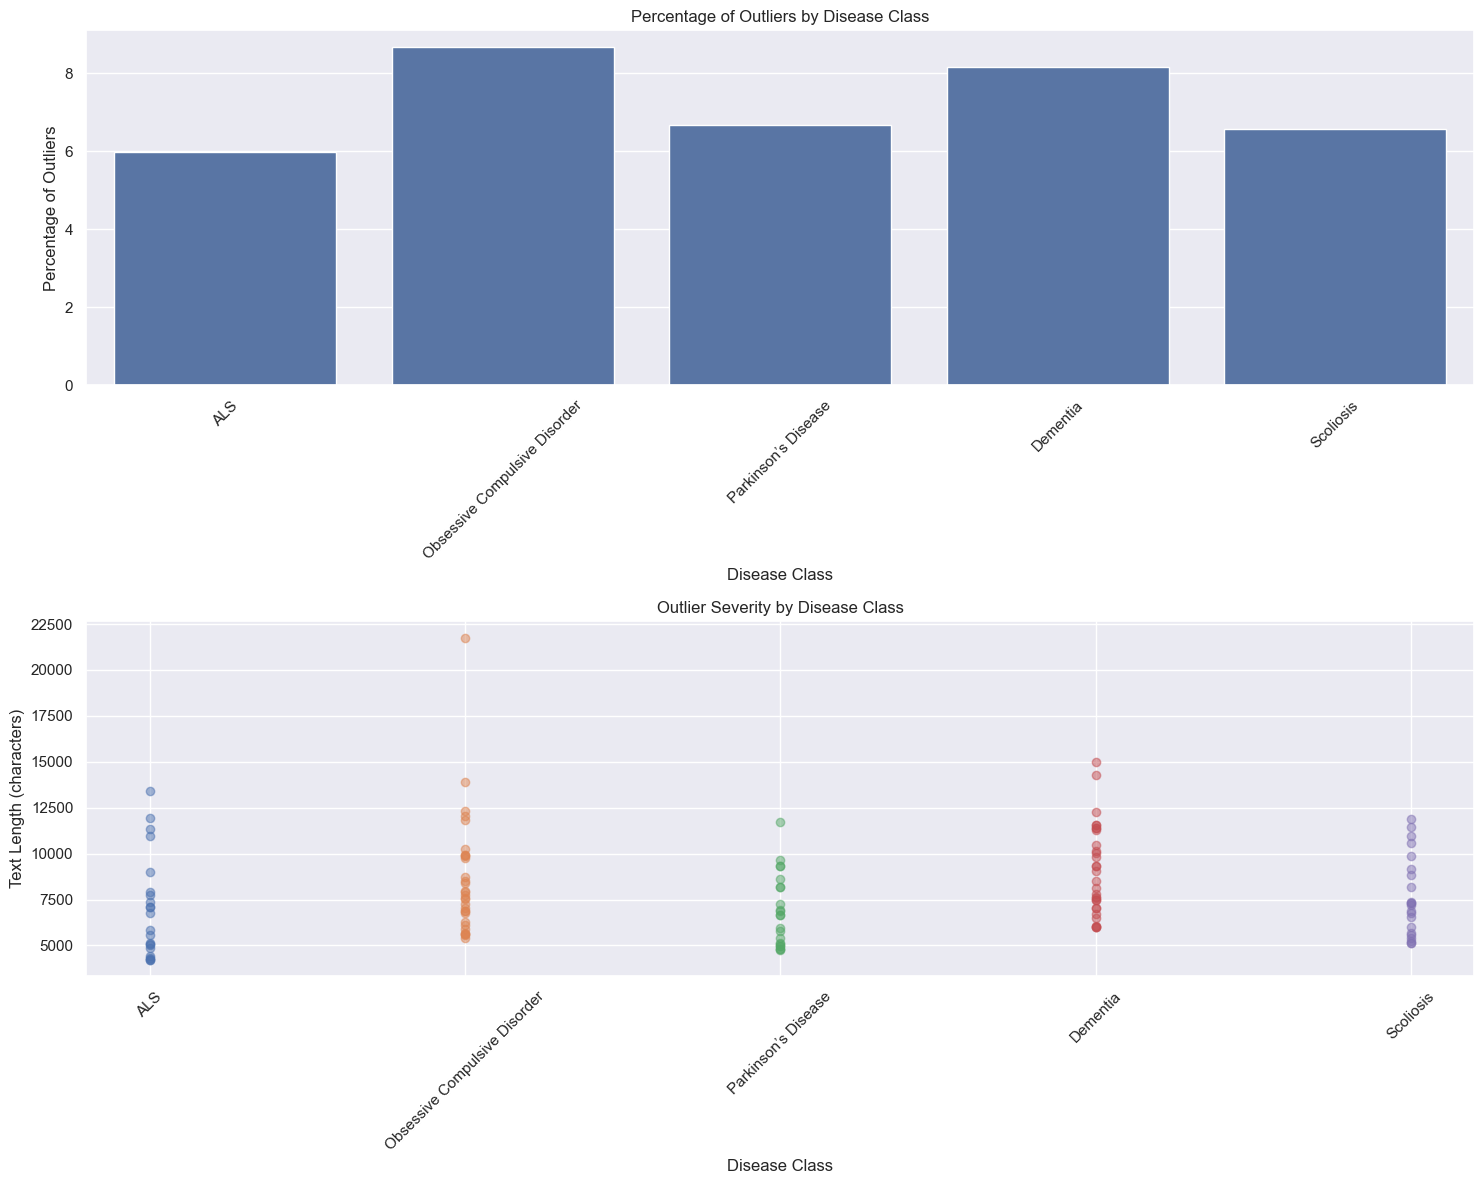

In [19]:
# Analyze outliers
outlier_analysis = analyze_outliers(df)

# Create visualizations
plot_path = 'figures/outlier_analysis.png'
plot_outlier_distribution(df, outlier_analysis, plot_path)

# Print insights
print_outlier_insights(outlier_analysis)

In [21]:
def identify_outliers(df: pd.DataFrame, threshold: float = 1.5) -> pd.DataFrame:
    """Identify outlier descriptions based on text length"""
    df['text_length'] = df['description'].str.len()
    outliers = []
    
    for label in df['label'].unique():
        class_data = df[df['label'] == label]['text_length']
        Q1 = class_data.quantile(0.25)
        Q3 = class_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + threshold * IQR
        
        class_outliers = df[
            (df['label'] == label) & 
            (df['text_length'] > upper_bound)
        ].copy()
        outliers.append(class_outliers)
    
    return pd.concat(outliers)

def analyze_section_patterns(text: str) -> Dict[str, bool]:
    """Analyze common section patterns in the text"""
    sections = {
        'inclusion_criteria': bool(re.search(r'inclusion criteria|eligibility criteria', text.lower())),
        'exclusion_criteria': bool(re.search(r'exclusion criteria', text.lower())),
        'study_design': bool(re.search(r'study design|trial design', text.lower())),
        'background': bool(re.search(r'background|introduction', text.lower())),
        'methodology': bool(re.search(r'methodology|methods|procedure', text.lower())),
        'outcome_measures': bool(re.search(r'outcome measures|endpoints', text.lower())),
        'statistical_analysis': bool(re.search(r'statistical analysis|statistics', text.lower()))
    }
    return sections

def analyze_content_structure(text: str) -> Dict:
    """Analyze structural elements of the text"""
    sentences = sent_tokenize(text)
    return {
        'num_sentences': len(sentences),
        'avg_sentence_length': np.mean([len(s.split()) for s in sentences]),
        'num_paragraphs': text.count('\n\n') + 1,
        'has_lists': bool(re.search(r'\n[-*•]|\d+\.', text)),
        'has_numbers': bool(re.search(r'\d+', text)),
        'has_measurements': bool(re.search(r'\d+\s*(mg|kg|ml|cm|weeks|months)', text))
    }

def analyze_medical_content(text: str) -> Dict:
    """Analyze medical-specific content patterns"""
    lower_text = text.lower()
    return {
        'has_dosage': bool(re.search(r'\d+\s*mg|\d+\s*kg', lower_text)),
        'has_duration': bool(re.search(r'\d+\s*(weeks?|months?|years?)', lower_text)),
        'has_medical_tests': bool(re.search(r'mri|ct scan|blood test|biopsy', lower_text)),
        'has_procedures': bool(re.search(r'surgery|procedure|treatment|therapy', lower_text)),
        'has_demographics': bool(re.search(r'age|gender|ethnicity|population', lower_text))
    }

def analyze_outlier_patterns(df: pd.DataFrame) -> Dict:
    """Analyze patterns in outlier descriptions"""
    outliers = identify_outliers(df)
    pattern_analysis = {label: [] for label in df['label'].unique()}
    
    for _, row in outliers.iterrows():
        text = row['description']
        label = row['label']
        
        # Analyze different aspects
        sections = analyze_section_patterns(text)
        structure = analyze_content_structure(text)
        medical = analyze_medical_content(text)
        
        pattern_analysis[label].append({
            'text_length': row['text_length'],
            'sections': sections,
            'structure': structure,
            'medical': medical
        })
    
    return pattern_analysis

def print_outlier_insights(pattern_analysis: Dict):
    """Print insights about outlier patterns for each class"""
    for label, analyses in pattern_analysis.items():
        if not analyses:
            continue
            
        logger.info(f"\n=== {label} Outlier Analysis ===")
        
        # Section presence
        section_stats = {
            section: sum(a['sections'][section] for a in analyses) / len(analyses) * 100
            for section in analyses[0]['sections'].keys()
        }
        logger.info("\nCommon Sections (% presence):")
        for section, percentage in sorted(section_stats.items(), key=lambda x: x[1], reverse=True):
            logger.info(f"- {section}: {percentage:.1f}%")
        
        # Structure statistics
        avg_sentences = np.mean([a['structure']['num_sentences'] for a in analyses])
        avg_sent_length = np.mean([a['structure']['avg_sentence_length'] for a in analyses])
        list_presence = sum(a['structure']['has_lists'] for a in analyses) / len(analyses) * 100
        
        logger.info("\nStructural Characteristics:")
        logger.info(f"- Average sentences: {avg_sentences:.1f}")
        logger.info(f"- Average sentence length: {avg_sent_length:.1f} words")
        logger.info(f"- Presence of lists: {list_presence:.1f}%")
        
        # Medical content
        medical_stats = {
            feature: sum(a['medical'][feature] for a in analyses) / len(analyses) * 100
            for feature in analyses[0]['medical'].keys()
        }
        logger.info("\nMedical Content (% presence):")
        for feature, percentage in sorted(medical_stats.items(), key=lambda x: x[1], reverse=True):
            logger.info(f"- {feature}: {percentage:.1f}%")



In [22]:
pattern_analysis = analyze_outlier_patterns(df)
print_outlier_insights(pattern_analysis)

{"timestamp": "2025-02-19T17:28:03.081030", "level": "INFO", "name": "__main__", "module": "3678857319", "function": "print_outlier_insights", "line": 103, "message": "\n=== ALS Outlier Analysis ===", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:28:03.081552", "level": "INFO", "name": "__main__", "module": "3678857319", "function": "print_outlier_insights", "line": 110, "message": "\nCommon Sections (% presence):", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:28:03.081978", "level": "INFO", "name": "__main__", "module": "3678857319", "function": "print_outlier_insights", "line": 112, "message": "- methodology: 36.4%", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:28:03.082378", "level": "INFO", "name": "__main__", "module": "3678857319", "function": "print_outlier_insights", "line": 112, "message": "- inclusion_criteria: 18.2%", "taskName": "Task-4"}
{"timestamp": "2025-02-19T17:28:03.082745", "level": "INFO", "name": "__main__", "module": "3678857319", "function": "pr

We found special information in how extended posts were dispersed throughout the dialogue. The OCD post reached 21,000 characters as its longest post, whereas dementia contained the most extensive range of lengthy posts. Posts about scoliosis maintained an even distribution between short and long lengths. The distribution of lengthy posts in ALS and Parkinson's disease research was moderate, as these studies contained some long articles without reaching extreme lengths.

Detailed medical information appeared as the main cause of lengthy posts, which included treatment steps together with clinical trial details as well as participant requirements and extensive explanations regarding the medical condition.

The analysis requires us to consider truncating our posts to 5,000 characters to include at least 95% of our existing content. Extra-long messages will require breaking into smaller sections, or we should modify their distribution length. Shorter posts require additional padding to establish consistent length along with other sections.

# Vocabulary size and distribution

In [6]:
def preprocess_text(text: str) -> List[str]:
    """Preprocess text by cleaning and tokenizing"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove single character tokens
    tokens = [token for token in tokens if len(token) > 1]
    
    return tokens

def analyze_vocabulary(df: pd.DataFrame) -> Tuple[Dict, pd.DataFrame]:
    """Analyze vocabulary statistics for each class"""
    vocab_stats = {}
    all_words = []
    
    # Analyze each class
    for label in df['label'].unique():
        class_docs = df[df['label'] == label]['description']
        
        # Process all documents in this class
        class_tokens = []
        for doc in class_docs:
            tokens = preprocess_text(doc)
            class_tokens.extend(tokens)
            all_words.extend(tokens)
        
        # Calculate statistics
        vocab_stats[label] = {
            'unique_words': len(set(class_tokens)),
            'total_words': len(class_tokens),
            'avg_words_per_doc': len(class_tokens) / len(class_docs),
            'top_words': Counter(class_tokens).most_common(10)
        }
    
    # Create word frequency distribution
    word_freq = pd.DataFrame(Counter(all_words).most_common(),
                           columns=['word', 'frequency'])
    
    return vocab_stats, word_freq

def plot_vocabulary_statistics(vocab_stats: Dict, word_freq: pd.DataFrame, save_path: str = None):
    """Create visualizations for vocabulary statistics"""
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Extract data for plotting
    labels = list(vocab_stats.keys())
    unique_words = [stats['unique_words'] for stats in vocab_stats.values()]
    avg_words = [stats['avg_words_per_doc'] for stats in vocab_stats.values()]
    
    # 1. Unique words per class
    sns.barplot(x=labels, y=unique_words, ax=ax1)
    ax1.set_title('Unique Words per Class')
    ax1.set_xlabel('Disease Class')
    ax1.set_ylabel('Number of Unique Words')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Average words per document
    sns.barplot(x=labels, y=avg_words, ax=ax2)
    ax2.set_title('Average Words per Document')
    ax2.set_xlabel('Disease Class')
    ax2.set_ylabel('Average Word Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Overall word frequency distribution (top 20)
    sns.barplot(x='frequency', y='word', 
                data=word_freq.head(20), ax=ax3)
    ax3.set_title('Top 20 Most Frequent Words')
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Word')
    
    # 4. Word frequency distribution (log scale)
    word_freq['rank'] = range(1, len(word_freq) + 1)
    word_freq['log_freq'] = np.log10(word_freq['frequency'])
    word_freq['log_rank'] = np.log10(word_freq['rank'])
    
    ax4.scatter(word_freq['log_rank'], word_freq['log_freq'], alpha=0.5)
    ax4.set_title('Zipf\'s Law Plot (Log-Log Scale)')
    ax4.set_xlabel('Log(Rank)')
    ax4.set_ylabel('Log(Frequency)')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def print_class_insights(vocab_stats: Dict):
    """Print insights about vocabulary statistics for each class"""
    for label, stats in vocab_stats.items():
        logger.info(f"\nClass: {label}")
        logger.info(f"Unique words: {stats['unique_words']}")
        logger.info(f"Total words: {stats['total_words']}")
        logger.info(f"Average words per document: {stats['avg_words_per_doc']:.2f}")
        logger.info("Top 10 words:")
        for word, count in stats['top_words']:
            logger.info(f"  - {word}: {count}")



{"timestamp": "2025-02-19T16:08:07.863661", "level": "INFO", "name": "__main__", "module": "4028163496", "function": "plot_vocabulary_statistics", "line": 123, "message": "Plot saved to figures/vocabulary_distribution.png", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:08:07.864272", "level": "INFO", "name": "__main__", "module": "4028163496", "function": "print_class_insights", "line": 133, "message": "\nClass: ALS", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:08:07.864616", "level": "INFO", "name": "__main__", "module": "4028163496", "function": "print_class_insights", "line": 134, "message": "Unique words: 8491", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:08:07.864970", "level": "INFO", "name": "__main__", "module": "4028163496", "function": "print_class_insights", "line": 135, "message": "Total words: 56404", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:08:07.865240", "level": "INFO", "name": "__main__", "module": "4028163496", "function": "print_class_ins

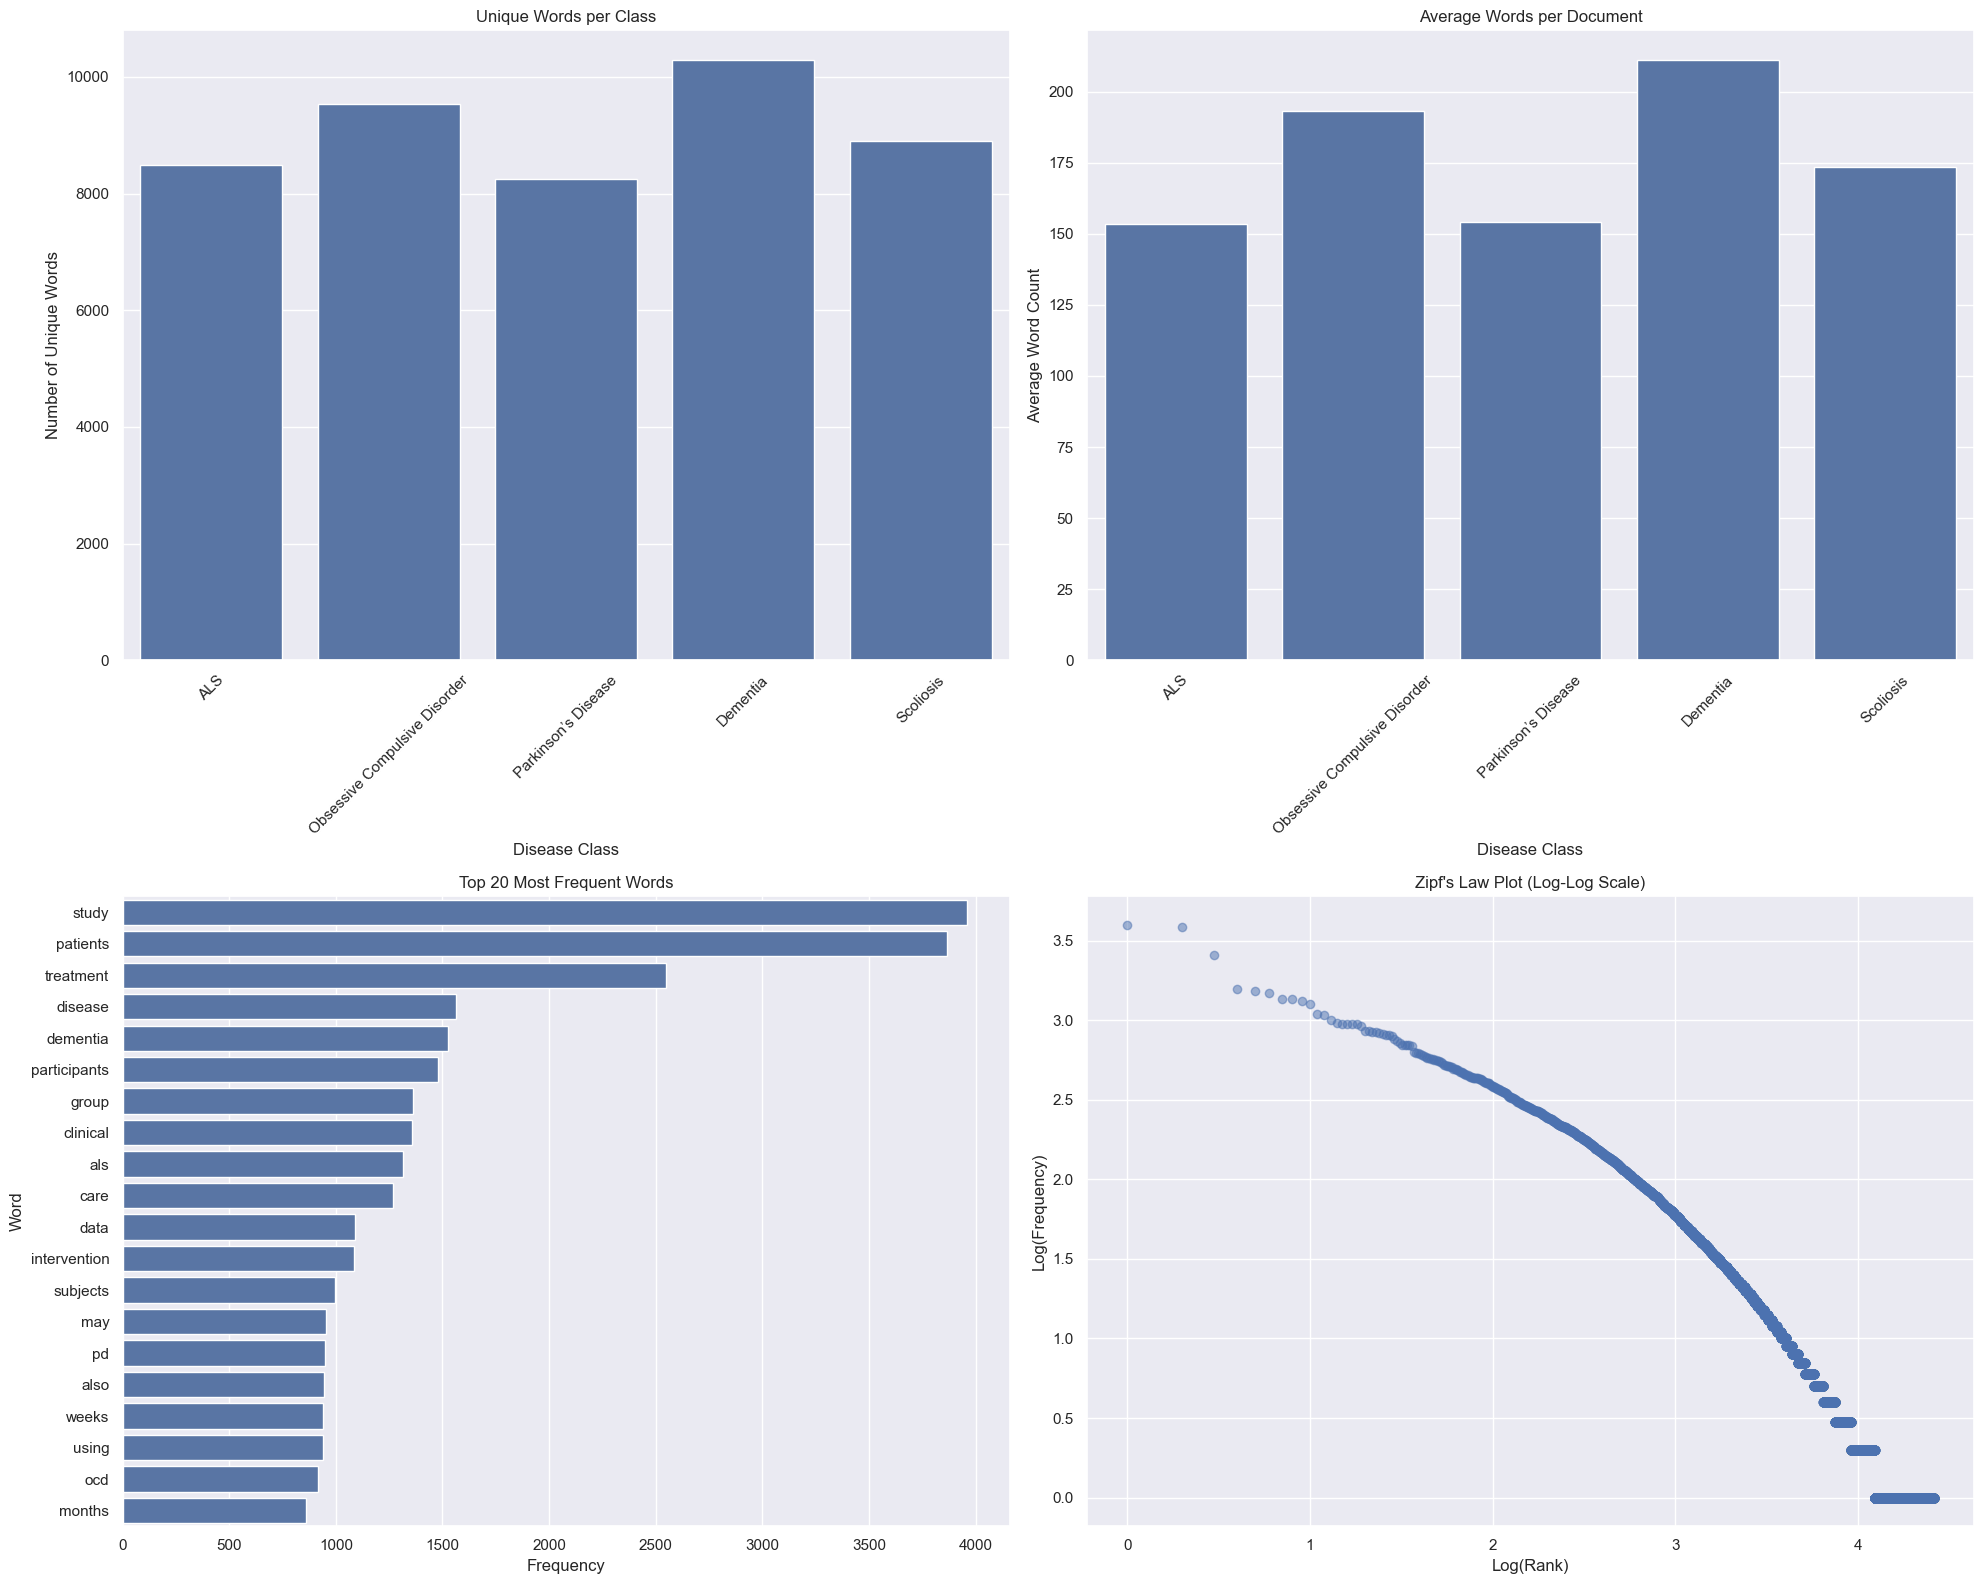

In [8]:
# Analyze vocabulary
vocab_stats, word_freq = analyze_vocabulary(df)

# Create plots
plot_path = 'figures/vocabulary_distribution.png'
plot_vocabulary_statistics(vocab_stats, word_freq, plot_path)

# Print insights
print_class_insights(vocab_stats)

# Additional statistics
logger.info("\nOverall Vocabulary Statistics:")
logger.info(f"Total unique words: {len(word_freq)}")
logger.info(f"Total words: {word_freq['frequency'].sum()}")
logger.info(f"Average word frequency: {word_freq['frequency'].mean():.2f}")


We observed significant language variations between the posts. Posts about dementia trials employed the most extensive vocabulary set with 10,000 distinct words and contained average descriptions of 210 words. The evidence shows that writers about dementia trials required more intricate approaches to provide explanations.

The descriptions for Parkinson's Disease alongside OCD and ALS and Scoliosis included 8,000 to 9,000 unique vocabulary items as well as relatively brief explanations throughout.

The random occurrence of "study," "patients," and "treatment" words appeared throughout every clinical trial condition. A few words appear often throughout the text, whereas most words tend to be used rarely, according to Zipf's law, which linguists identify. The dataset contains everyday words that are presented repeatedly, but medical-specific terms seem to appear only two times throughout the information.

# Specific vocabulary differences between classes

In [16]:
def analyze_class_specific_vocabulary(df: pd.DataFrame, min_freq: int = 10) -> Dict:
    """Analyze vocabulary differences between classes"""
    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        stop_words='english',
        min_df=min_freq,
        token_pattern=r'(?u)\b[A-Za-z]+\b'
    )
    
    # Fit TF-IDF on all documents
    tfidf_matrix = tfidf.fit_transform(df['description'])
    feature_names = tfidf.get_feature_names_out()
    
    class_analysis = {}
    
    # Analyze each class
    for label in df['label'].unique():
        class_mask = df['label'] == label
        class_indices = np.where(class_mask)[0]  # Get indices where class_mask is True
    
        # Create the inverse mask using np.where
        other_indices = np.where(~class_mask)[0]
    
        class_tfidf = tfidf_matrix[class_indices].mean(axis=0).A1
        other_tfidf = tfidf_matrix[other_indices].mean(axis=0).A1  # Use other_indices
    
        # Get top words by TF-IDF score
        top_indices = class_tfidf.argsort()[-20:][::-1]
        top_words = [(feature_names[i], class_tfidf[i]) for i in top_indices]
    
        # Find distinctive words (high TF-IDF in this class vs others)
        distinctiveness = class_tfidf - other_tfidf
        distinctive_indices = distinctiveness.argsort()[-20:][::-1]
        distinctive_words = [(feature_names[i], distinctiveness[i]) for i in distinctive_indices]
    
        class_analysis[label] = {
            'top_words': top_words,
            'distinctive_words': distinctive_words
        }    

    return class_analysis

def plot_class_vocabulary_comparison(class_analysis: Dict, save_path: str = None):
    """Create visualizations for vocabulary differences between classes"""
    n_classes = len(class_analysis)
    fig, axes = plt.subplots(n_classes, 2, figsize=(20, 6*n_classes))
    
    for idx, (label, analysis) in enumerate(class_analysis.items()):
        # Plot top words
        words, scores = zip(*analysis['top_words'][:15])
        sns.barplot(x=list(scores), y=list(words), ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Top Words - {label}')
        axes[idx, 0].set_xlabel('TF-IDF Score')
        
        # Plot distinctive words
        words, scores = zip(*analysis['distinctive_words'][:15])
        sns.barplot(x=list(scores), y=list(words), ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Distinctive Words - {label}')
        axes[idx, 1].set_xlabel('Distinctiveness Score')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def analyze_vocabulary_overlap(class_analysis: Dict) -> pd.DataFrame:
    """Analyze vocabulary overlap between classes"""
    classes = list(class_analysis.keys())
    overlap_matrix = np.zeros((len(classes), len(classes)))
    
    for i, class1 in enumerate(classes):
        words1 = set(word for word, _ in class_analysis[class1]['top_words'])
        for j, class2 in enumerate(classes):
            words2 = set(word for word, _ in class_analysis[class2]['top_words'])
            overlap = len(words1.intersection(words2)) / len(words1.union(words2))
            overlap_matrix[i, j] = overlap
    
    return pd.DataFrame(overlap_matrix, index=classes, columns=classes)

def print_vocabulary_insights(class_analysis: Dict):
    """Print insights about vocabulary differences between classes"""
    for label, analysis in class_analysis.items():
        logger.info(f"\nClass: {label}")
        
        logger.info("\nTop 10 Most Important Words:")
        for word, score in analysis['top_words'][:10]:
            logger.info(f"  - {word}: {score:.4f}")
        
        logger.info("\nTop 10 Most Distinctive Words:")
        for word, score in analysis['distinctive_words'][:10]:
            logger.info(f"  - {word}: {score:.4f}")


{"timestamp": "2025-02-19T16:45:22.107687", "level": "INFO", "name": "__main__", "module": "2436038805", "function": "plot_class_vocabulary_comparison", "line": 80, "message": "Plot saved to figures/vocabulary_differences.png", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:45:22.197576", "level": "INFO", "name": "__main__", "module": "2436038805", "function": "print_vocabulary_insights", "line": 112, "message": "\nClass: ALS", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:45:22.198026", "level": "INFO", "name": "__main__", "module": "2436038805", "function": "print_vocabulary_insights", "line": 114, "message": "\nTop 10 Most Important Words:", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:45:22.198314", "level": "INFO", "name": "__main__", "module": "2436038805", "function": "print_vocabulary_insights", "line": 116, "message": "  - als: 0.1748", "taskName": "Task-4"}
{"timestamp": "2025-02-19T16:45:22.198678", "level": "INFO", "name": "__main__", "module": "2436038805", 

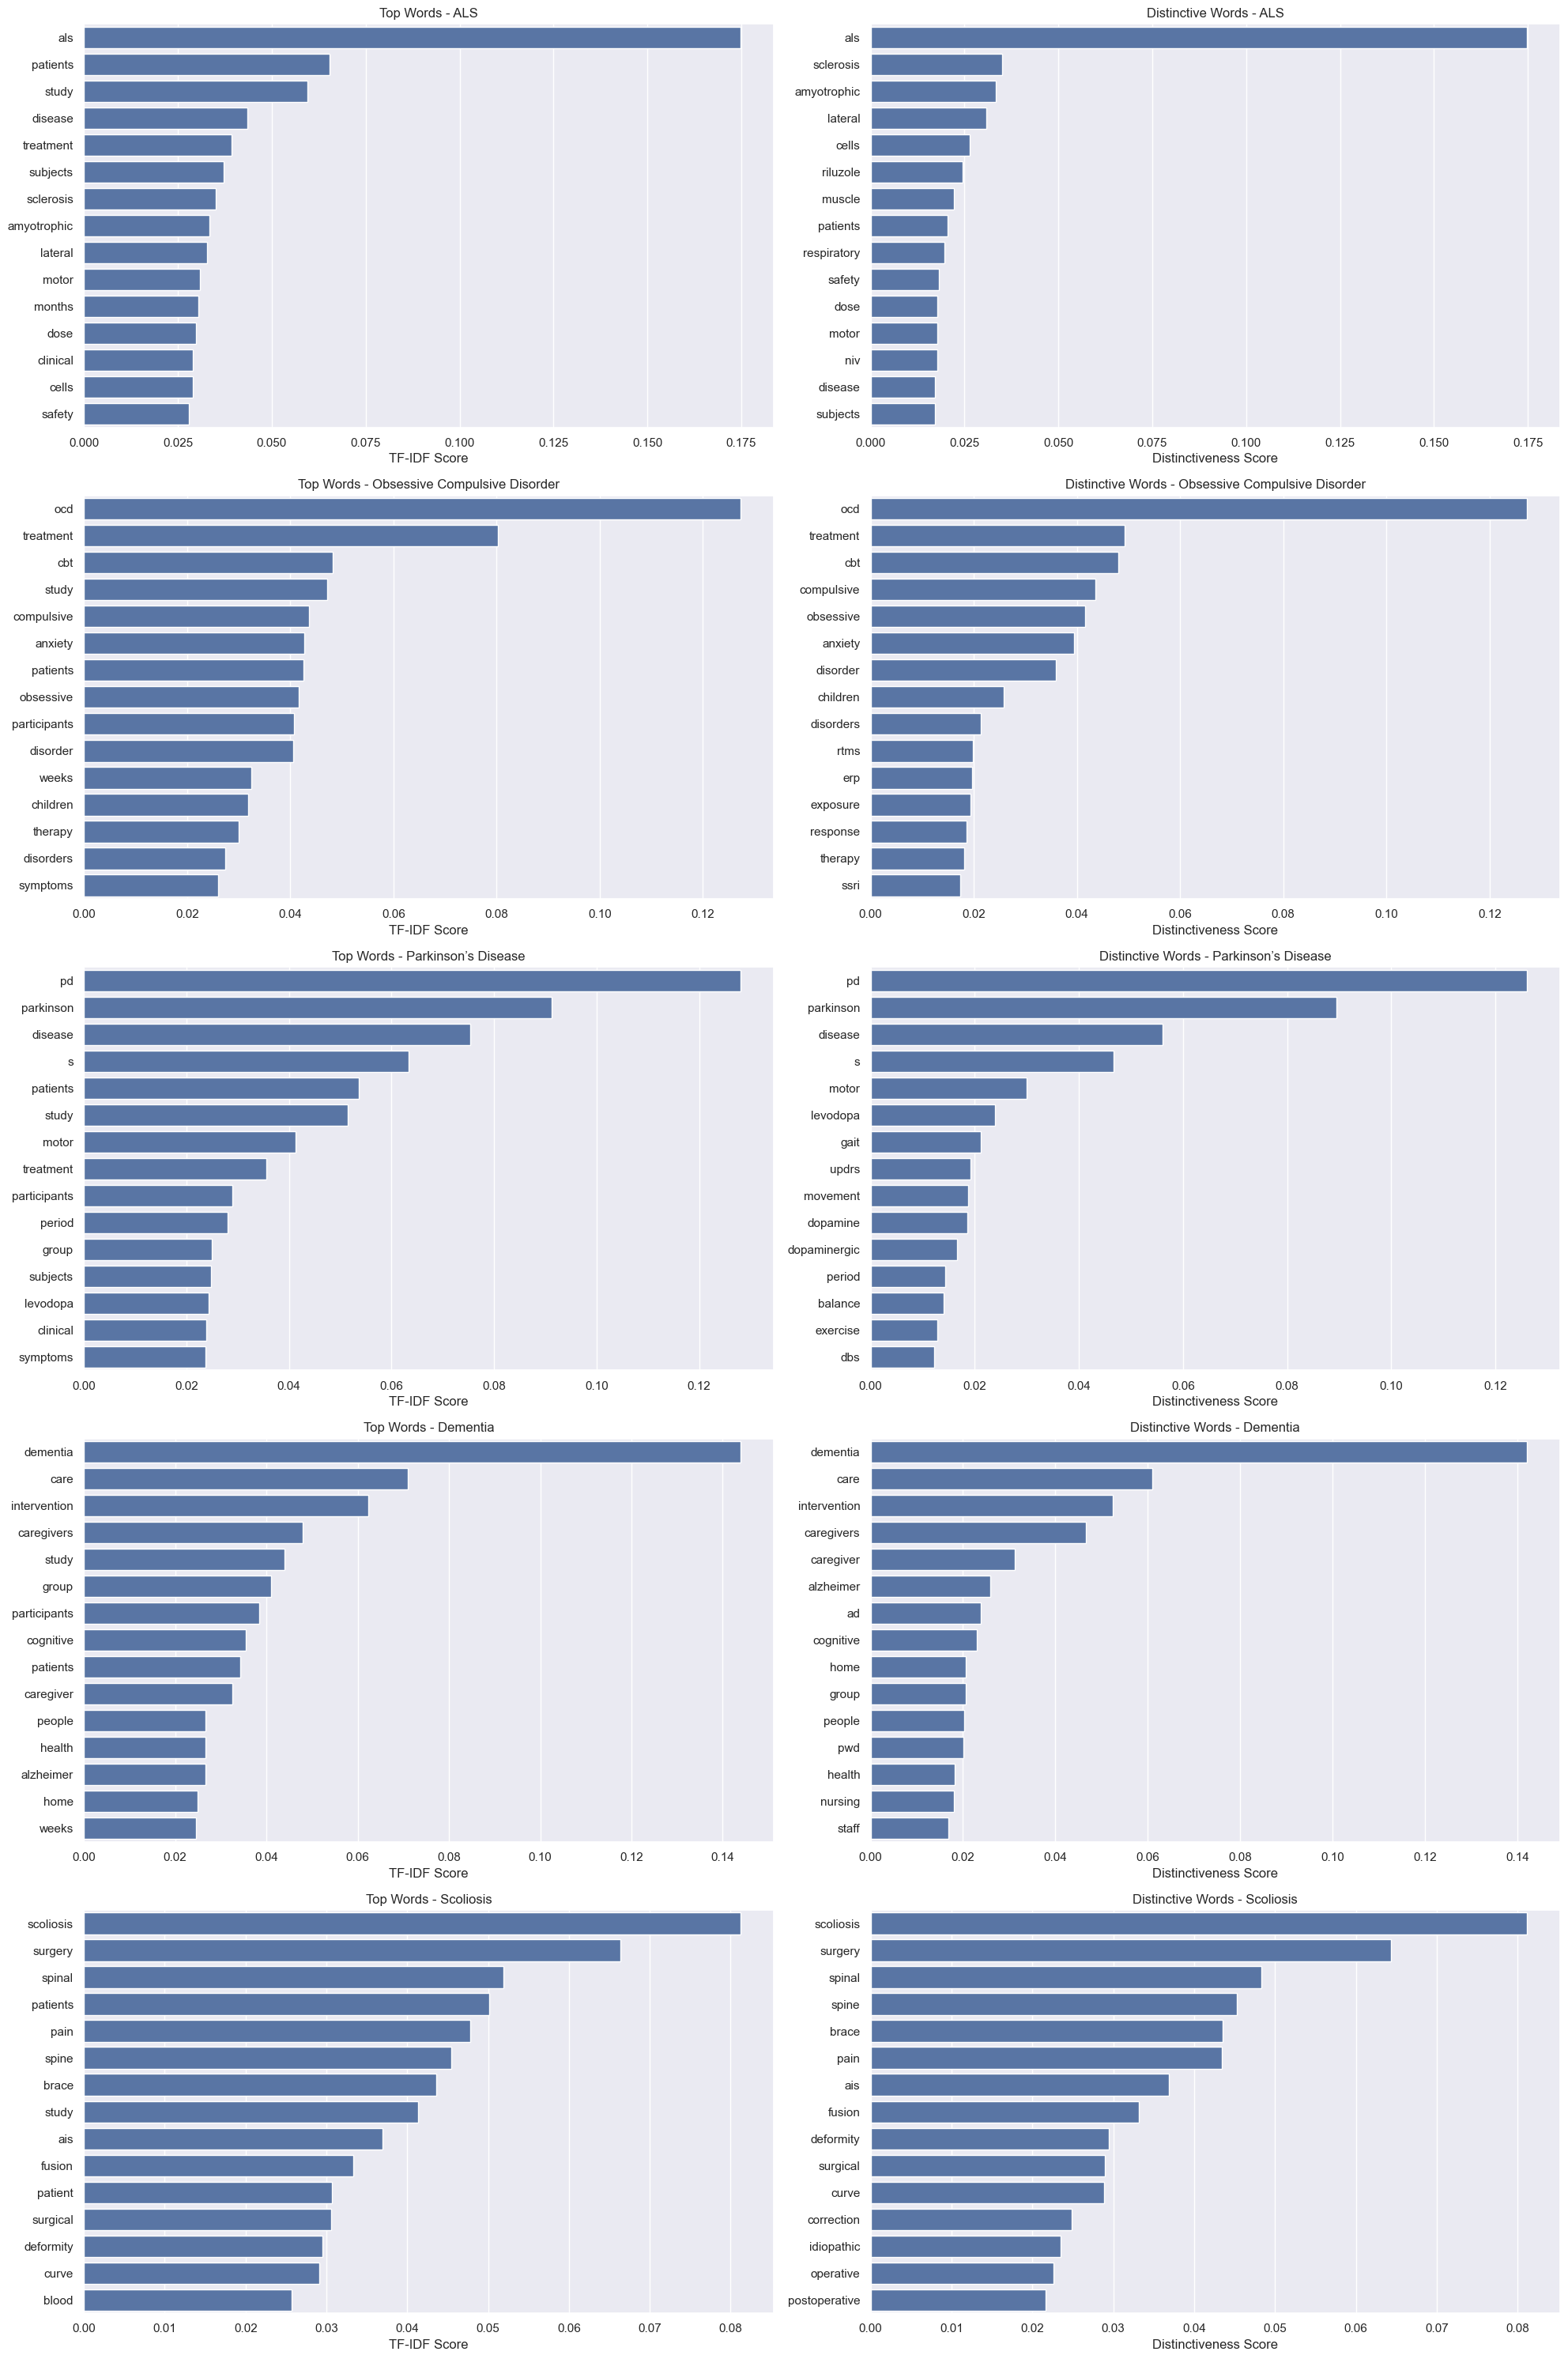

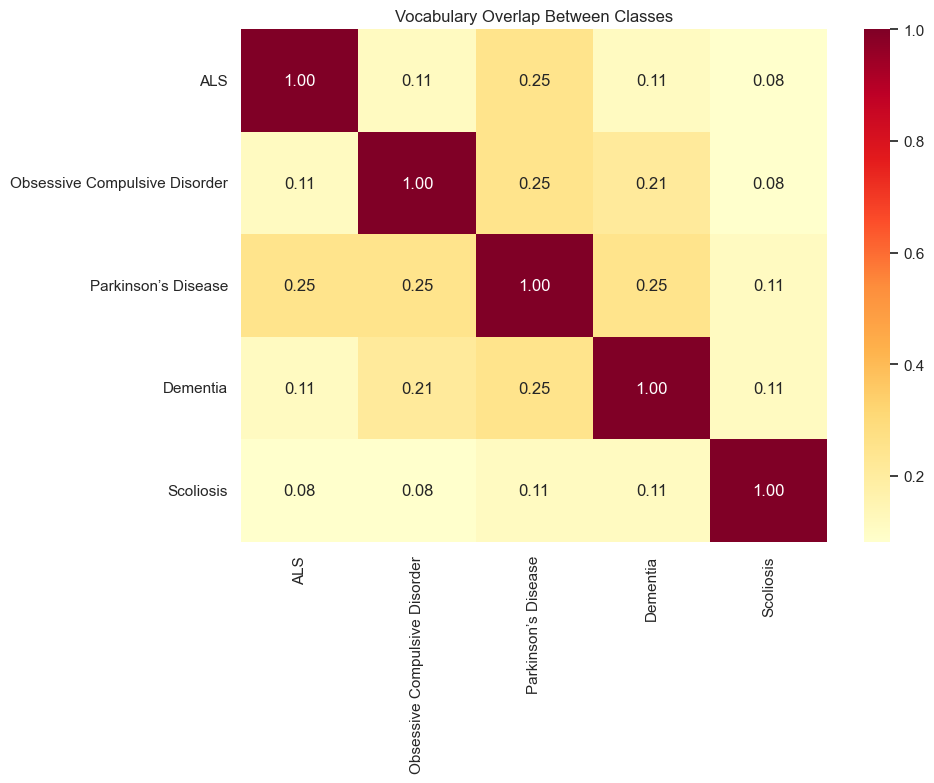

In [17]:
# Analyze vocabulary differences
class_analysis = analyze_class_specific_vocabulary(df)

# Create visualizations
plot_path = 'figures/vocabulary_differences.png'
plot_class_vocabulary_comparison(class_analysis, plot_path)

# Analyze vocabulary overlap
overlap_df = analyze_vocabulary_overlap(class_analysis)

# Plot overlap heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Vocabulary Overlap Between Classes')
plt.tight_layout()
plt.savefig('figures/vocabulary_overlap.png')

# Print insights
print_vocabulary_insights(class_analysis)

logger.info("\nVocabulary Overlap Summary:")
logger.info("\n" + str(overlap_df))


The language of fingerprints differs among each condition. The discussion about ALS mainly involves the impacts of the disease on nervous systems and body functions while utilising vocabulary such as "sclerosis" and ventilatory difficulties. The discussions about OCD emphasise behaviours together with therapeutic approaches where "compulsive" actions and cognitive behavioural therapy (CBT) receive numerous mentions.

Parkinson's online discussions focus on movement difficulties and treatment approaches, which include regular discussions regarding "motor" issues and the use of levodopa. Posts about dementia feature information about memory deterioration and mental processing problems together with repeated "cognitive" decline notices and Alzheimer's disease descriptions. The discussion includes many fragments about the delivery of care to individuals. Scoliosis stands out the most because it employs precise terms about spinal curves and regularly describes surgical processes.

The neurological conditions ALS Parkinson's and dementia use roughly 25% of overlapping terminology in their posts since their collective impacts affect shared body systems. The medical terms between OCD and scoliosis overlap only between 8-11% with other disease categories.

Our analysis reveals an important finding that scoliosis will display the clearest symptoms to an automatic philtre because of its distinctive linguistic patterns. Brain-related conditions will require additional detailed evaluation since their language includes many shared elements, so context analysis becomes essential to separate them.

# Class distribution

In [9]:
def analyze_class_distribution(df: pd.DataFrame) -> Tuple[Dict, pd.DataFrame]:
    """Analyze the distribution of disease classes in the dataset"""
    # Calculate class distribution
    class_counts = df['label'].value_counts()
    total_samples = len(df)
    
    # Create distribution DataFrame
    distribution_df = pd.DataFrame({
        'count': class_counts,
        'percentage': (class_counts / total_samples * 100).round(2)
    }).sort_values('count', ascending=False)
    
    # Calculate statistics
    stats = {
        'total_samples': total_samples,
        'num_classes': len(class_counts),
        'largest_class': class_counts.index[0],
        'largest_class_count': class_counts.iloc[0],
        'smallest_class': class_counts.index[-1],
        'smallest_class_count': class_counts.iloc[-1],
        'imbalance_ratio': class_counts.iloc[0] / class_counts.iloc[-1]
    }
    
    return stats, distribution_df

def plot_class_distribution(df: pd.DataFrame, save_path: str = None):
    """Create visualizations for class distribution"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Bar plot of class counts
    sns.barplot(
        data=df,
        y='label',
        x='count',
        ax=ax1,
        palette='viridis'
    )
    ax1.set_title('Disease Class Distribution')
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('Disease Class')
    
    # Add count labels on bars
    for i, v in enumerate(df['count']):
        ax1.text(v, i, f' {v}', va='center')
    
    # 2. Pie chart of class percentages
    ax2.pie(
        df['percentage'],
        labels=df.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis', n_colors=len(df))
    )
    ax2.set_title('Disease Class Distribution (%)')
    
    # 3. Normalized stacked bar
    df_cumsum = df['percentage'].cumsum()
    sns.barplot(
        x=[1],
        y=[100],
        color='lightgrey',
        ax=ax3
    )
    
    colors = sns.color_palette('viridis', n_colors=len(df))
    bottom = 0
    
    for idx, (label, percentage) in enumerate(df['percentage'].items()):
        ax3.bar(
            0,
            percentage,
            bottom=bottom,
            color=colors[idx],
            label=label
        )
        # Add percentage labels
        ax3.text(
            0,
            bottom + percentage/2,
            f'{percentage:.1f}%',
            ha='center',
            va='center'
        )
        bottom += percentage
    
    ax3.set_title('Normalized Class Distribution')
    ax3.set_xlabel('')
    ax3.set_ylabel('Percentage')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Cumulative distribution
    ax4.plot(
        range(1, len(df) + 1),
        df_cumsum,
        marker='o'
    )
    ax4.set_title('Cumulative Class Distribution')
    ax4.set_xlabel('Number of Classes')
    ax4.set_ylabel('Cumulative Percentage')
    ax4.grid(True)
    
    # Add percentage labels
    for i, v in enumerate(df_cumsum):
        ax4.text(i + 1, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def print_distribution_insights(stats: Dict, distribution_df: pd.DataFrame):
    """Print insights about class distribution"""
    logger.info("\n=== Class Distribution Analysis ===")
    logger.info(f"Total number of samples: {stats['total_samples']}")
    logger.info(f"Number of classes: {stats['num_classes']}")
    logger.info(f"\nClass distribution:")
    for idx, row in distribution_df.iterrows():
        logger.info(f"- {idx}: {row['count']} samples ({row['percentage']:.1f}%)")
    
    logger.info(f"\nLargest class: {stats['largest_class']} ({stats['largest_class_count']} samples)")
    logger.info(f"Smallest class: {stats['smallest_class']} ({stats['smallest_class_count']} samples)")
    logger.info(f"Imbalance ratio: {stats['imbalance_ratio']:.2f}")


/var/folders/w5/xv2mxvzn2ns0szm6w3260jym0000gn/T/ipykernel_99896/3269879791.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


{"timestamp": "2025-02-20T07:43:07.607224", "level": "INFO", "name": "__main__", "module": "3269879791", "function": "plot_class_distribution", "line": 126, "message": "Plot saved to figures/class_distribution.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T07:43:07.607696", "level": "INFO", "name": "__main__", "module": "3269879791", "function": "print_distribution_insights", "line": 130, "message": "\n=== Class Distribution Analysis ===", "taskName": "Task-4"}
{"timestamp": "2025-02-20T07:43:07.607934", "level": "INFO", "name": "__main__", "module": "3269879791", "function": "print_distribution_insights", "line": 131, "message": "Total number of samples: 1759", "taskName": "Task-4"}
{"timestamp": "2025-02-20T07:43:07.608425", "level": "INFO", "name": "__main__", "module": "3269879791", "function": "print_distribution_insights", "line": 132, "message": "Number of classes: 5", "taskName": "Task-4"}
{"timestamp": "2025-02-20T07:43:07.608815", "level": "INFO", "name": "__main__", "

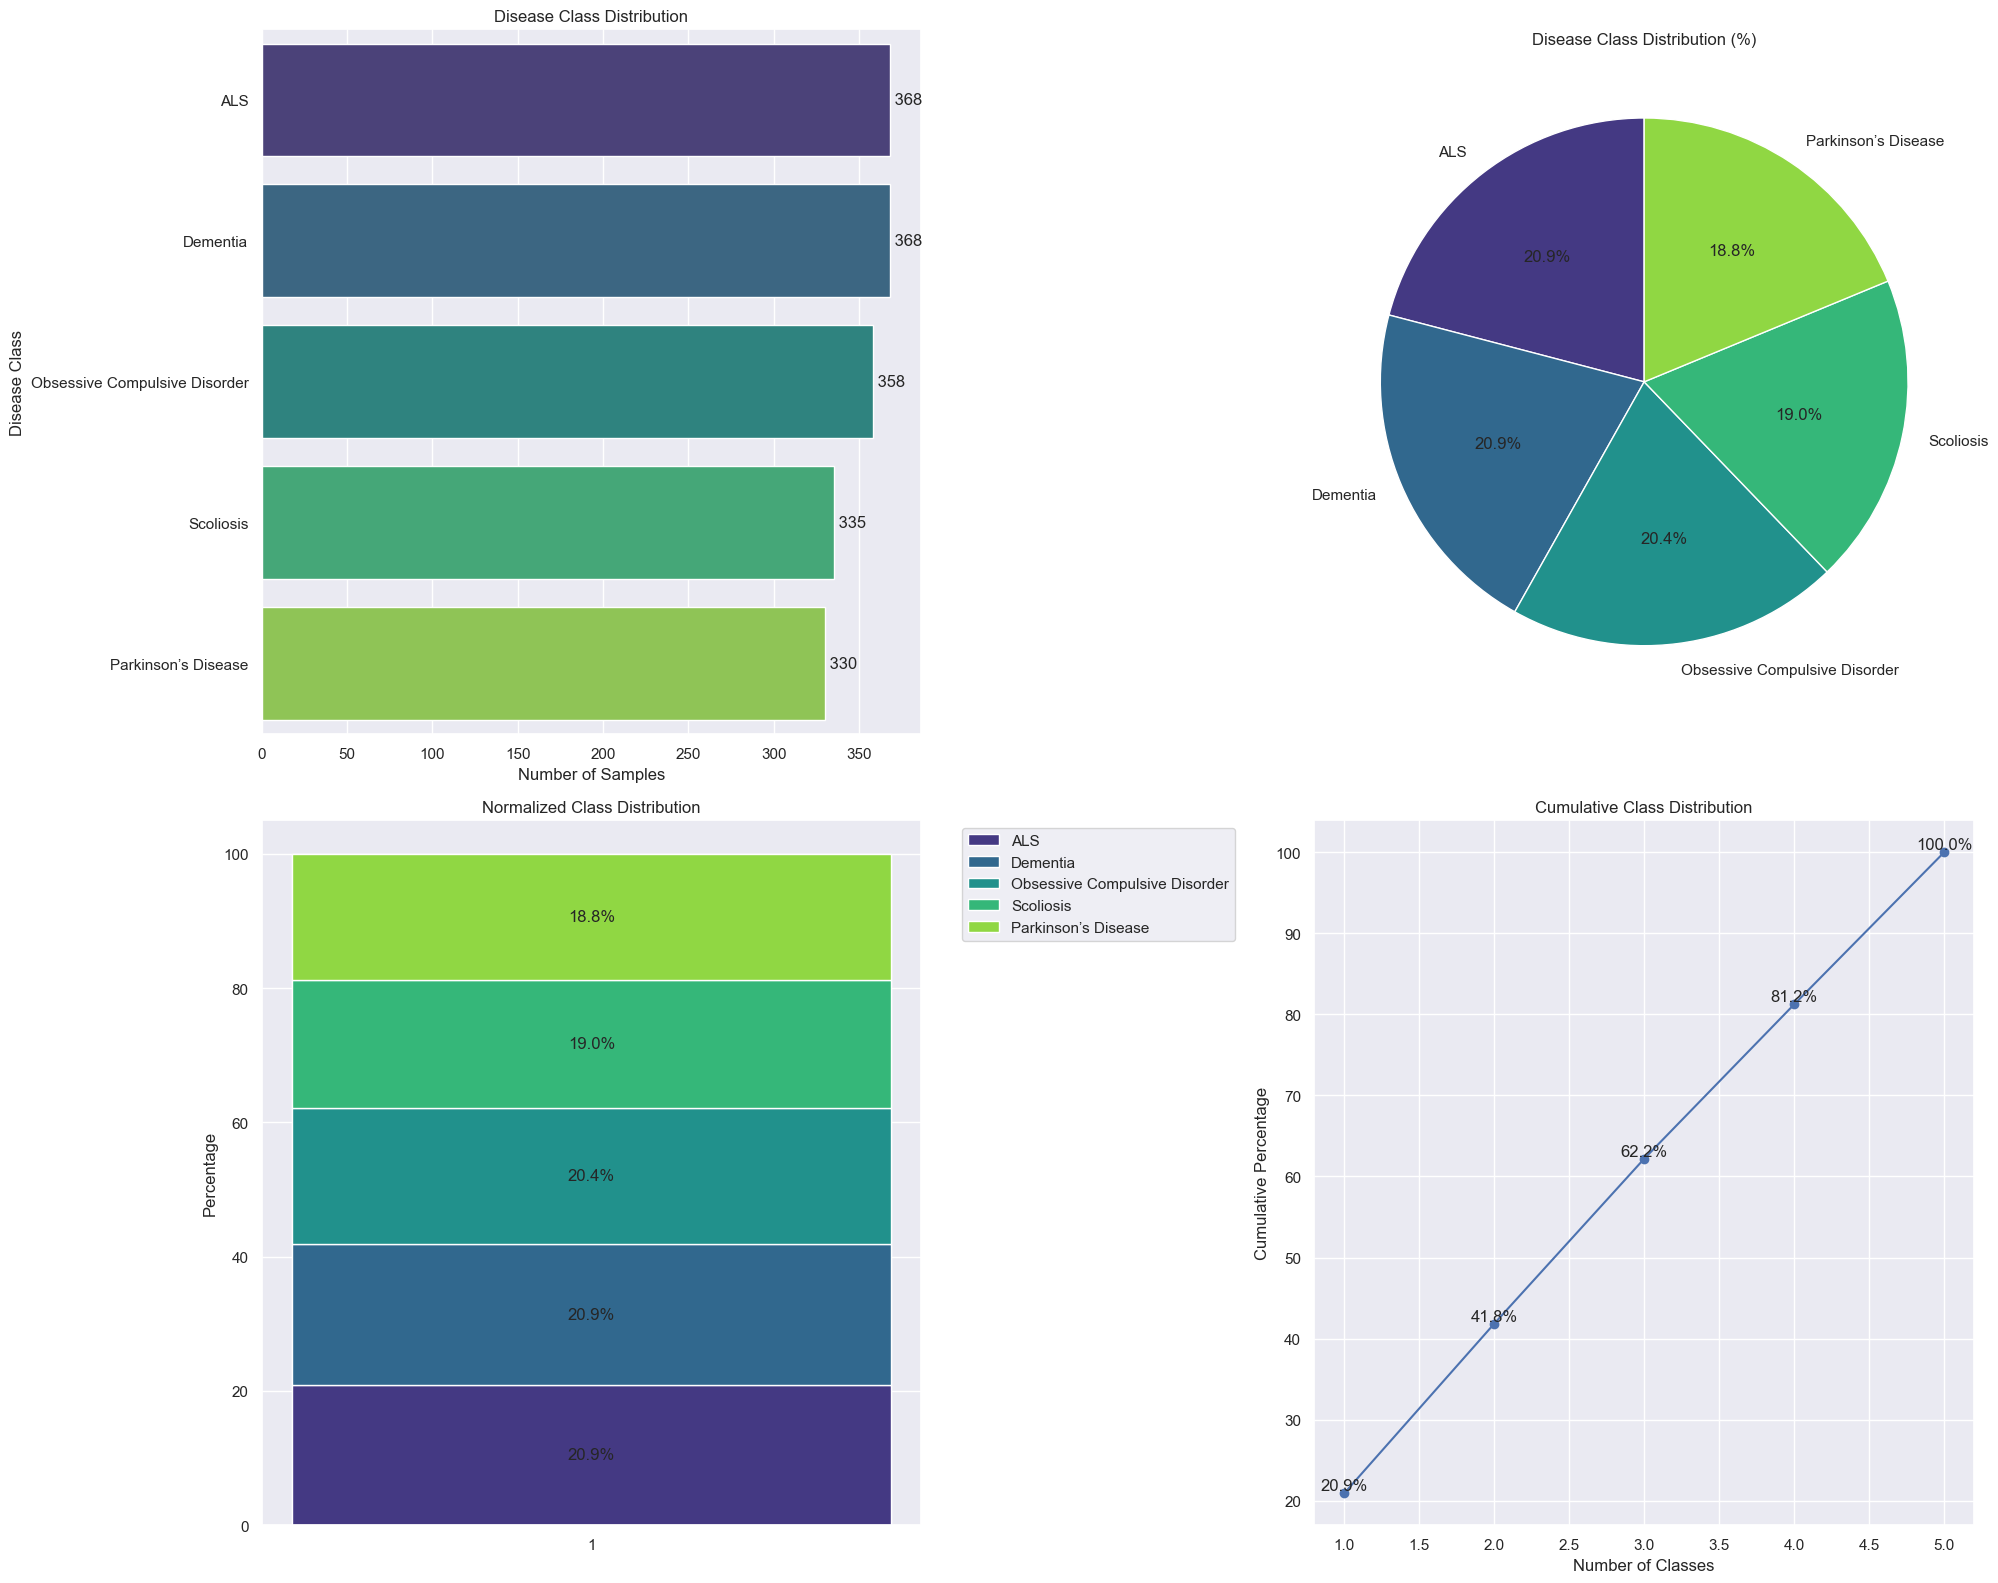

In [10]:
# Analyze distribution
stats, distribution_df = analyze_class_distribution(df)

# Create visualizations
plot_path = 'figures/class_distribution.png'
plot_class_distribution(distribution_df, plot_path)

# Print insights
print_distribution_insights(stats, distribution_df)

Our dataset brings fortune since its distribution among disease categories proves almost equal. Every disease category corresponds to 19-21% of the overall dataset, constituting almost perfect balance. The biggest categorical difference holds only 38 samples, thereby making the most populous group 1.12 times greater than the least prevalent one.

We can observe a completely uniform pattern in the data visualisation regardless of using bar graphs or pie charts or cumulative curves. Every disease category maintains a smooth transition without sudden changes between them.

An even distribution simplifies the work process for us. Our testing and validation segmentation needs standard approaches rather than complex sample adjustment methods since the distribution is so even within the data. We can skip elaborate methods for generating extra samples from minor categories or implementing special balancing techniques because of an even data distribution. Standard k-fold cross-validation provides the solution for this problem.

# Missing data

In [20]:
def analyze_missing_data(df: pd.DataFrame) -> Dict:
    """Analyze missing data patterns in the dataset"""
    # Basic missing value analysis
    missing_stats = {
        'total_cells': np.prod(df.shape),
        'missing_cells': df.isna().sum().sum(),
        'missing_percentage': (df.isna().sum().sum() / np.prod(df.shape) * 100),
        'columns_with_missing': df.columns[df.isna().any()].tolist(),
        'missing_by_column': df.isna().sum().to_dict(),
        'missing_by_column_pct': (df.isna().sum() / len(df) * 100).to_dict()
    }
    
    # Check for empty strings and whitespace
    empty_stats = {
        'empty_strings': (df == '').sum().to_dict(),
        'whitespace_only': df.apply(
            lambda x: x.str.isspace().sum() if x.dtype == 'object' else 0
        ).to_dict()
    }
    
    # Analysis by disease class
    missing_by_class = {}
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        missing_by_class[label] = {
            'total_samples': len(class_df),
            'missing_values': class_df.isna().sum().to_dict(),
            'missing_percentage': (class_df.isna().sum() / len(class_df) * 100).to_dict()
        }
    
    return {
        'basic_stats': missing_stats,
        'empty_stats': empty_stats,
        'class_stats': missing_by_class
    }

def check_data_quality(df: pd.DataFrame) -> Dict:
    """Check for potential data quality issues"""
    quality_checks = {}
    
    # Check description lengths
    quality_checks['description_length'] = {
        'min_length': df['description'].str.len().min(),
        'max_length': df['description'].str.len().max(),
        'mean_length': df['description'].str.len().mean(),
        'zero_length': (df['description'].str.len() == 0).sum(),
        'very_short': (df['description'].str.len() < 50).sum()  # Potentially too short
    }
    
    # Check for potential invalid entries
    quality_checks['potential_issues'] = {
        'invalid_chars': df['description'].str.contains(r'[^\w\s\.,;:\-\(\)]').sum(),
        'multiple_spaces': df['description'].str.contains(r'\s{2,}').sum(),
        'special_chars': df['description'].str.contains(r'[^\x00-\x7F]').sum()
    }
    
    # Check for duplicates
    quality_checks['duplicates'] = {
        'exact_duplicates': df.duplicated().sum(),
        'description_duplicates': df['description'].duplicated().sum()
    }
    
    return quality_checks

def plot_missing_data(df: pd.DataFrame, save_path: str = None):
    """Create visualizations for missing data analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Missing values heatmap
    sns.heatmap(
        df.isna(),
        yticklabels=False,
        cbar=False,
        cmap='viridis',
        ax=ax1
    )
    ax1.set_title('Missing Values Heatmap')
    
    # 2. Missing values by column
    missing_by_col = df.isna().sum()
    sns.barplot(
        x=missing_by_col.index,
        y=missing_by_col.values,
        ax=ax2
    )
    ax2.set_title('Missing Values by Column')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right") 
    
    # 3. Missing values by class
    missing_by_class = df.groupby('label').apply(lambda x: x.drop('label', axis=1).isna().sum())
    sns.heatmap(
        missing_by_class,
        annot=True,
        fmt='g',
        cmap='YlOrRd',
        ax=ax3
    )
    ax3.set_title('Missing Values by Class')
    
    # 4. Description length distribution
    df['description_length'] = df['description'].str.len()
    sns.boxplot(
        x='label',
        y='description_length',
        data=df,
        ax=ax4
    )
    ax4.set_title('Description Length Distribution by Class')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def print_data_quality_insights(analysis_results: Dict, quality_results: Dict):
    """Print insights about data quality and missing values"""
    logger.info("\n=== Missing Data Analysis ===")
    basic_stats = analysis_results['basic_stats']
    logger.info(f"Total cells in dataset: {basic_stats['total_cells']}")
    logger.info(f"Missing cells: {basic_stats['missing_cells']}")
    logger.info(f"Overall missing percentage: {basic_stats['missing_percentage']:.2f}%")
    
    if basic_stats['columns_with_missing']:
        logger.info("\nColumns with missing values:")
        for col in basic_stats['columns_with_missing']:
            pct = basic_stats['missing_by_column_pct'][col]
            logger.info(f"- {col}: {pct:.2f}%")
    
    logger.info("\n=== Data Quality Analysis ===")
    desc_stats = quality_results['description_length']
    logger.info(f"Description length stats:")
    logger.info(f"- Min length: {desc_stats['min_length']}")
    logger.info(f"- Max length: {desc_stats['max_length']}")
    logger.info(f"- Mean length: {desc_stats['mean_length']:.2f}")
    logger.info(f"- Zero length entries: {desc_stats['zero_length']}")
    logger.info(f"- Very short descriptions: {desc_stats['very_short']}")
    
    issues = quality_results['potential_issues']
    logger.info("\nPotential data quality issues:")
    logger.info(f"- Invalid characters: {issues['invalid_chars']}")
    logger.info(f"- Multiple spaces: {issues['multiple_spaces']}")
    logger.info(f"- Special characters: {issues['special_chars']}")
    
    dupes = quality_results['duplicates']
    logger.info("\nDuplicate entries:")
    logger.info(f"- Exact duplicates: {dupes['exact_duplicates']}")
    logger.info(f"- Description duplicates: {dupes['description_duplicates']}")


/var/folders/w5/xv2mxvzn2ns0szm6w3260jym0000gn/T/ipykernel_99896/1016578636.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_class = df.groupby('label').apply(lambda x: x.drop('label', axis=1).isna().sum())


{"timestamp": "2025-02-20T08:05:32.107664", "level": "INFO", "name": "__main__", "module": "1016578636", "function": "plot_missing_data", "line": 140, "message": "Plot saved to figures/missing_data_analysis.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:05:32.108559", "level": "INFO", "name": "__main__", "module": "1016578636", "function": "print_data_quality_insights", "line": 144, "message": "\n=== Missing Data Analysis ===", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:05:32.108873", "level": "INFO", "name": "__main__", "module": "1016578636", "function": "print_data_quality_insights", "line": 146, "message": "Total cells in dataset: 7036", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:05:32.109183", "level": "INFO", "name": "__main__", "module": "1016578636", "function": "print_data_quality_insights", "line": 147, "message": "Missing cells: 0", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:05:32.109436", "level": "INFO", "name": "__main__", "module": "1016

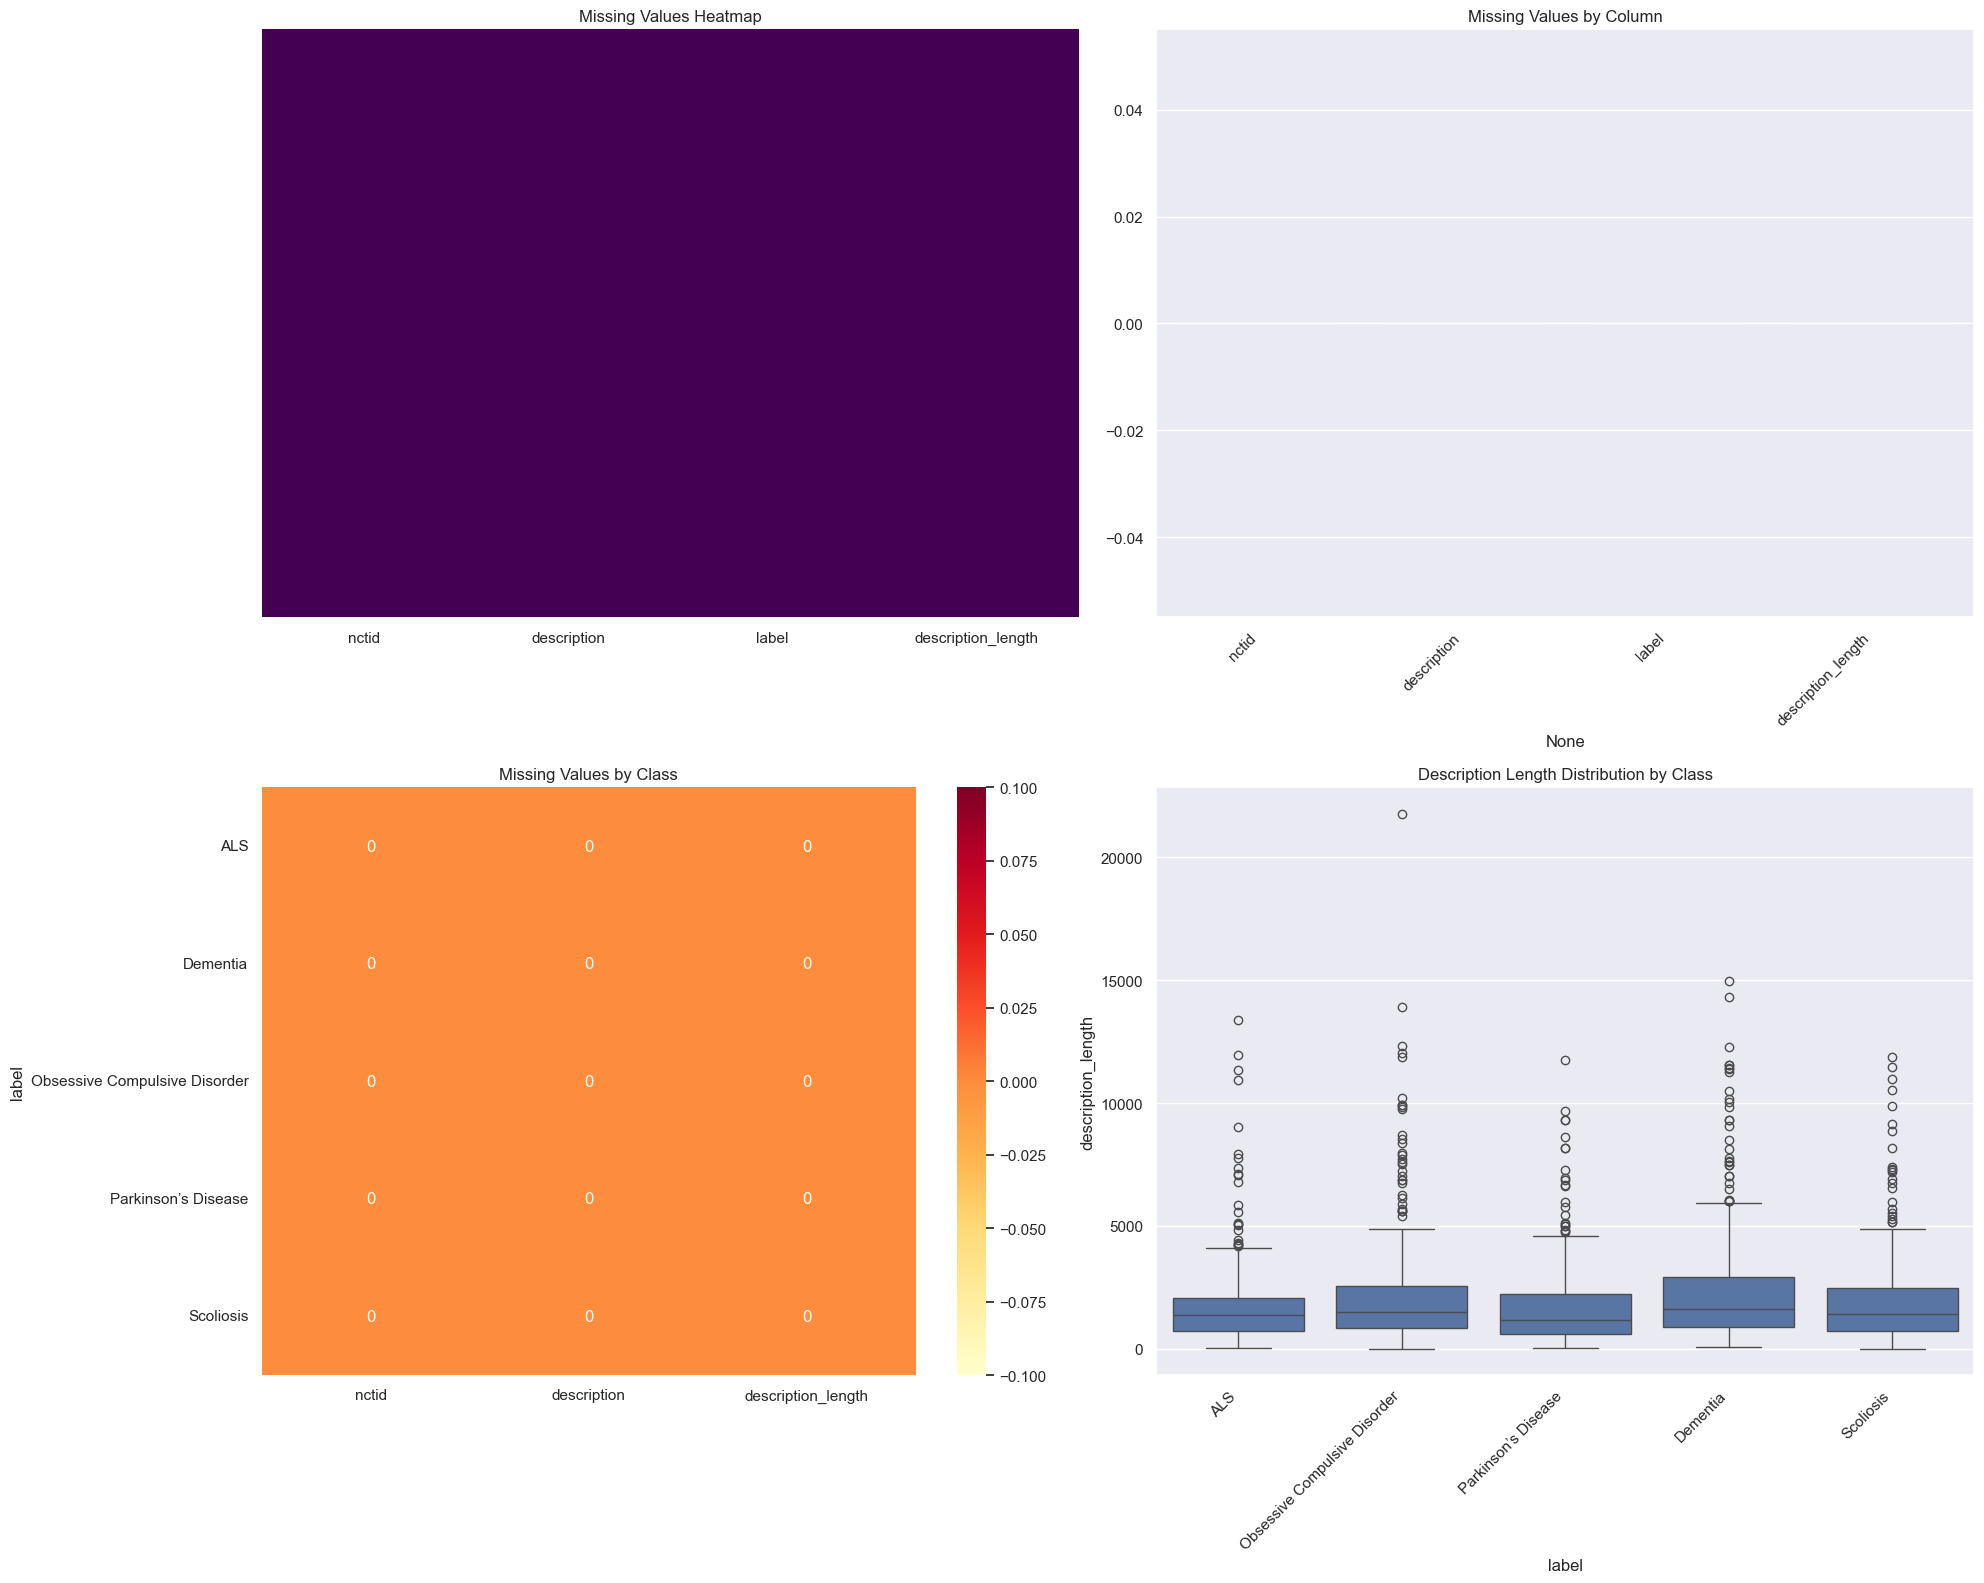

In [21]:
# Analyze missing data
analysis_results = analyze_missing_data(df)
quality_results = check_data_quality(df)

# Create visualizations
plot_path = 'figures/missing_data_analysis.png'
plot_missing_data(df, plot_path)

# Print insights
print_data_quality_insights(analysis_results, quality_results)


We have no missing data.

# Special character analysis

In [22]:
def identify_special_characters(text: str) -> List[str]:
    """Extract special characters from text"""
    # Regular expression to match special characters
    special_chars = re.findall(r'[^a-zA-Z0-9\s]', text)
    return special_chars

def analyze_special_characters(df: pd.DataFrame) -> Dict:
    """Analyze special character distribution in the dataset"""
    analysis = {
        'overall': {},
        'by_class': {},
        'patterns': {}
    }
    
    # Overall analysis
    all_special_chars = []
    for text in df['description']:
        chars = identify_special_characters(text)
        all_special_chars.extend(chars)
    
    char_counts = Counter(all_special_chars)
    
    analysis['overall'] = {
        'total_special_chars': len(all_special_chars),
        'unique_special_chars': len(char_counts),
        'most_common': char_counts.most_common(20),
        'avg_per_document': len(all_special_chars) / len(df)
    }
    
    # Analysis by class
    for label in df['label'].unique():
        class_chars = []
        class_texts = df[df['label'] == label]['description']
        
        for text in class_texts:
            chars = identify_special_characters(text)
            class_chars.extend(chars)
            
        class_counts = Counter(class_chars)
        
        analysis['by_class'][label] = {
            'total_special_chars': len(class_chars),
            'unique_special_chars': len(class_counts),
            'most_common': class_counts.most_common(10),
            'avg_per_document': len(class_chars) / len(class_texts)
        }
    
    # Identify common patterns
    common_patterns = [
        (r'\d+%', 'percentage'),
        (r'\d+\.\d+', 'decimal_numbers'),
        (r'\([^)]*\)', 'parentheses'),
        (r'\[[^\]]*\]', 'brackets'),
        (r'\d+/\d+', 'fractions'),
        (r'\d+±\d+', 'plus_minus'),
        (r'\d+\s*mg', 'milligrams'),
        (r'\d+\s*kg', 'kilograms'),
        (r'\d+\s*ml', 'milliliters'),
        (r'\d+\s*-\s*\d+', 'ranges')
    ]
    
    for pattern, pattern_name in common_patterns:
        pattern_counts = df['description'].str.count(pattern).sum()
        analysis['patterns'][pattern_name] = pattern_counts
    
    return analysis

def plot_special_characters(df: pd.DataFrame, analysis: Dict, save_path: str = None):
    """Create visualizations for special character analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Most common special characters overall
    chars, counts = zip(*analysis['overall']['most_common'][:15])
    sns.barplot(x=list(chars), y=list(counts), ax=ax1)
    ax1.set_title('Most Common Special Characters')
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Count')
    
    # 2. Special characters by class
    class_data = []
    for label, stats in analysis['by_class'].items():
        class_data.append({
            'label': label,
            'avg_chars': stats['avg_per_document']
        })
    class_df = pd.DataFrame(class_data)
    
    sns.barplot(x='label', y='avg_chars', data=class_df, ax=ax2)
    ax2.set_title('Average Special Characters per Document by Class')
    ax2.set_xlabel('Disease Class')
    ax2.set_ylabel('Average Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Common patterns distribution
    patterns = list(analysis['patterns'].keys())
    pattern_counts = list(analysis['patterns'].values())
    
    sns.barplot(x=pattern_counts, y=patterns, ax=ax3)
    ax3.set_title('Common Pattern Frequencies')
    ax3.set_xlabel('Count')
    ax3.set_ylabel('Pattern Type')
    
    # 4. Special character density heatmap
    char_density = pd.DataFrame(
        [Counter(identify_special_characters(text)) for text in df['description']],
        index=df['label']
    ).fillna(0)
    
    # Select top 10 most common characters for visibility
    top_chars = pd.DataFrame(char_density).sum().nlargest(10).index
    char_density = char_density[top_chars]
    
    sns.heatmap(
        char_density.groupby(level=0).mean(),
        cmap='YlOrRd',
        annot=True,
        fmt='.2f',
        ax=ax4
    )
    ax4.set_title('Special Character Density by Class')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def print_special_char_insights(analysis: Dict):
    """Print insights about special character usage"""
    logger.info("\n=== Special Character Analysis ===")
    
    # Overall statistics
    logger.info("\nOverall Statistics:")
    logger.info(f"Total special characters: {analysis['overall']['total_special_chars']}")
    logger.info(f"Unique special characters: {analysis['overall']['unique_special_chars']}")
    logger.info(f"Average per document: {analysis['overall']['avg_per_document']:.2f}")
    
    # Most common characters
    logger.info("\nMost common special characters:")
    for char, count in analysis['overall']['most_common'][:10]:
        logger.info(f"- '{char}': {count} occurrences")
    
    # Class-specific insights
    logger.info("\nClass-specific patterns:")
    for label, stats in analysis['by_class'].items():
        logger.info(f"\n{label}:")
        logger.info(f"- Average per document: {stats['avg_per_document']:.2f}")
        logger.info("- Most common characters:")
        for char, count in stats['most_common'][:5]:
            logger.info(f"  '{char}': {count} occurrences")
    
    # Common patterns
    logger.info("\nCommon patterns found:")
    for pattern, count in analysis['patterns'].items():
        logger.info(f"- {pattern}: {count} occurrences")


{"timestamp": "2025-02-20T08:09:58.464035", "level": "INFO", "name": "__main__", "module": "1802851634", "function": "plot_special_characters", "line": 149, "message": "Plot saved to figures/special_characters.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:09:58.464865", "level": "INFO", "name": "__main__", "module": "1802851634", "function": "print_special_char_insights", "line": 153, "message": "\n=== Special Character Analysis ===", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:09:58.465147", "level": "INFO", "name": "__main__", "module": "1802851634", "function": "print_special_char_insights", "line": 156, "message": "\nOverall Statistics:", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:09:58.465422", "level": "INFO", "name": "__main__", "module": "1802851634", "function": "print_special_char_insights", "line": 157, "message": "Total special characters: 103733", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:09:58.465688", "level": "INFO", "name": "__main__"

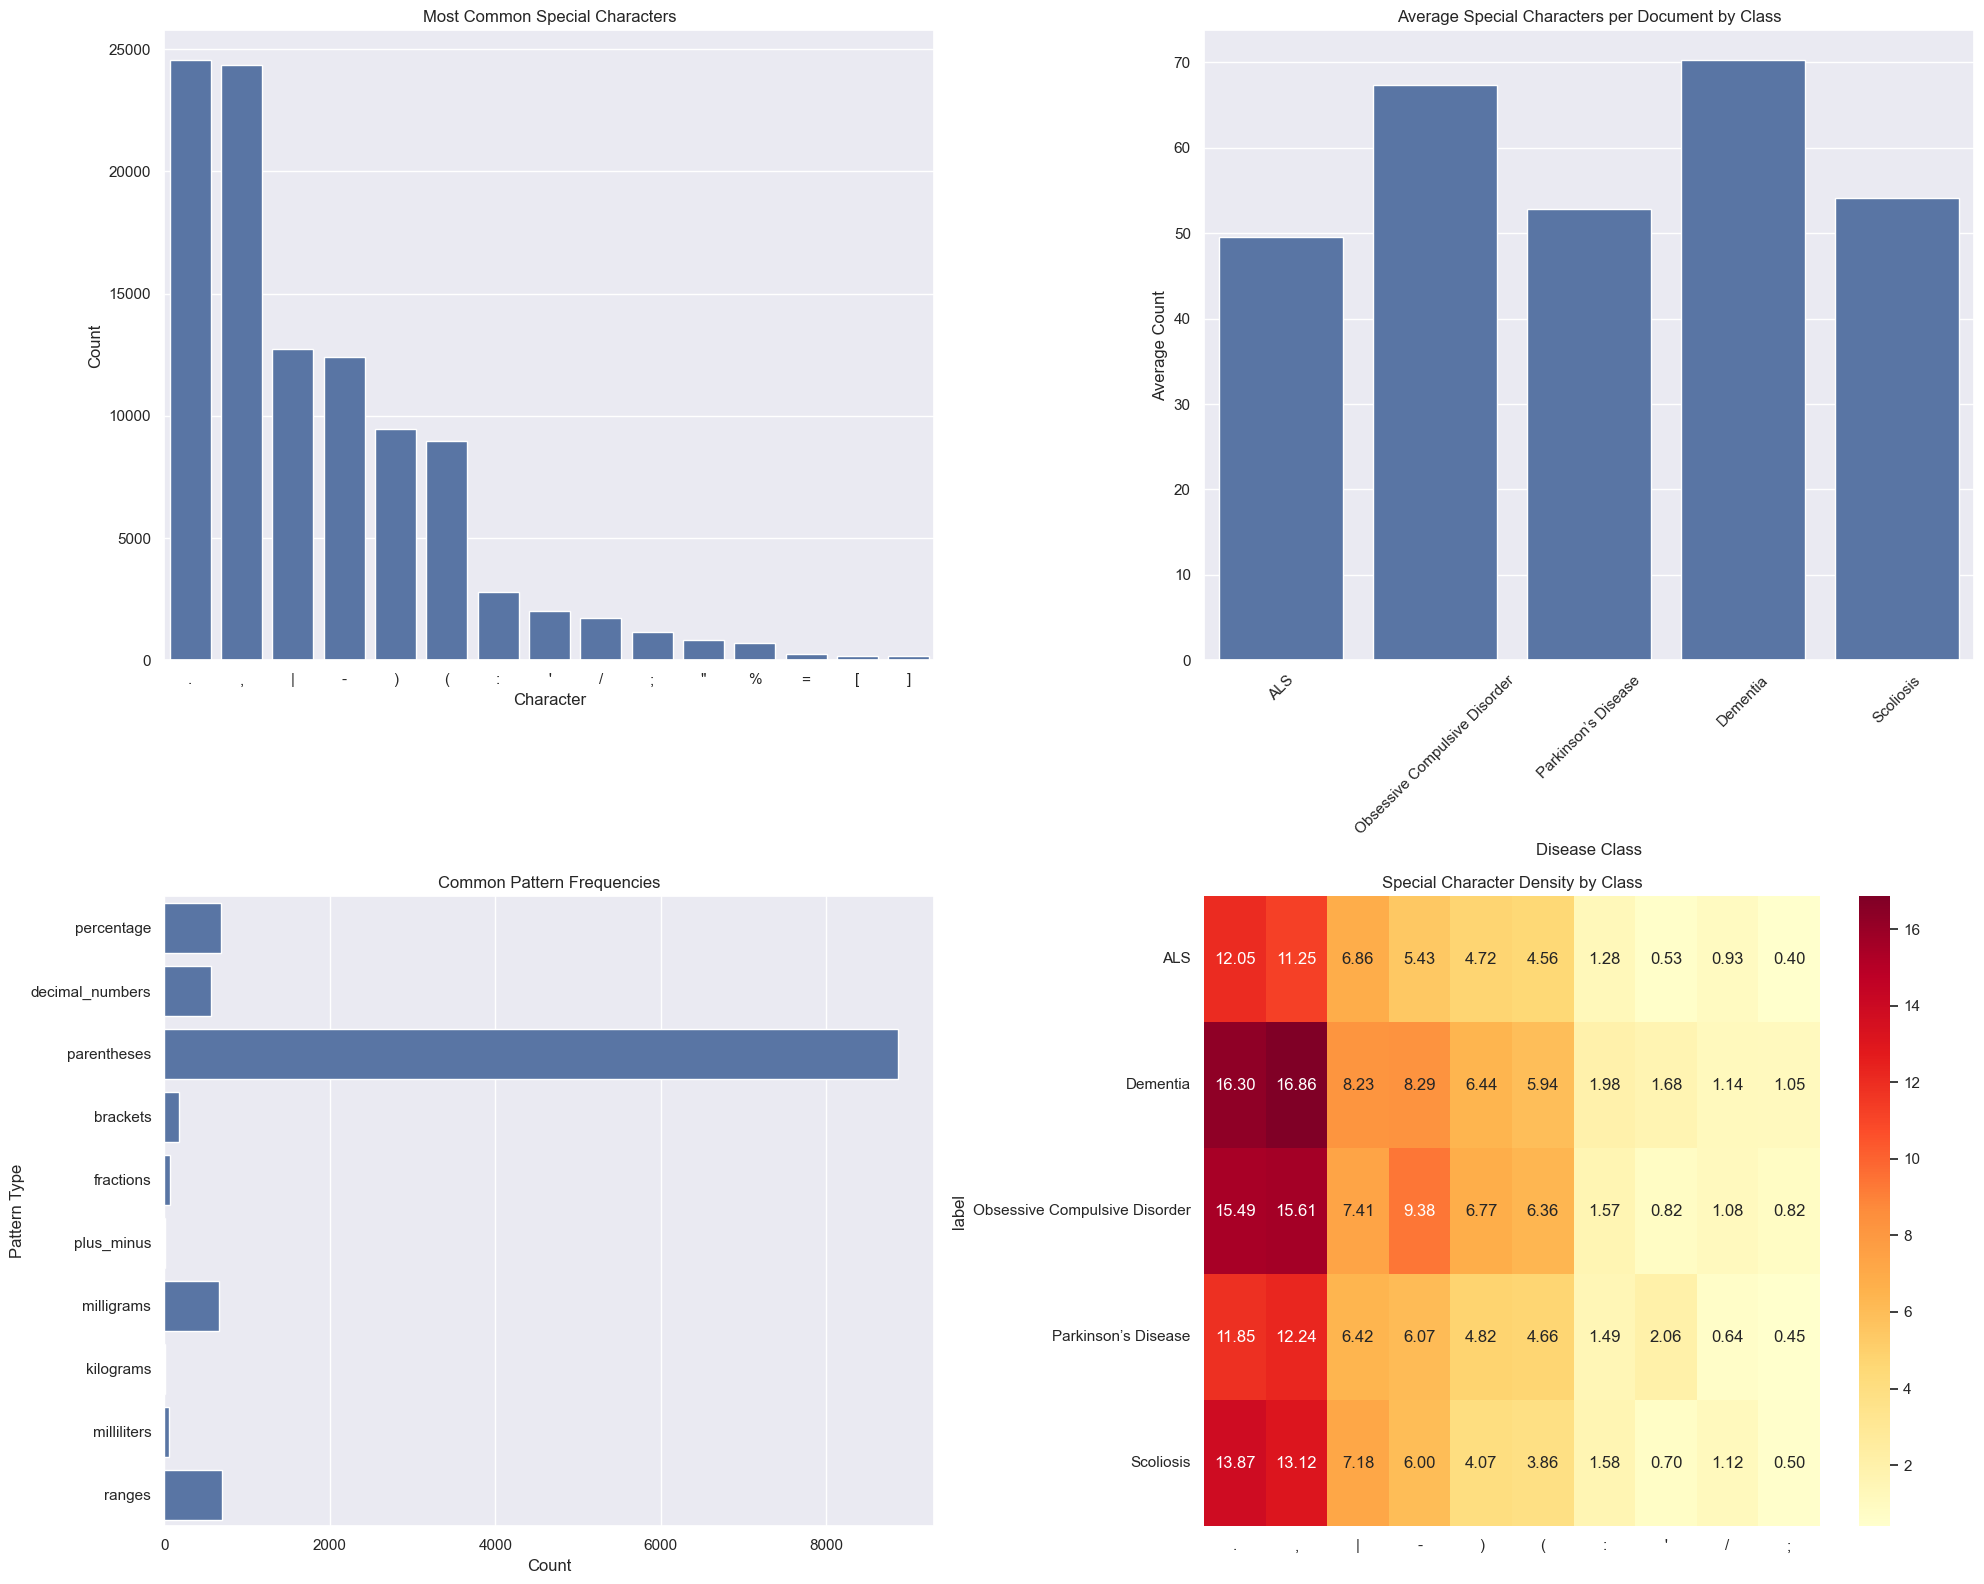

In [24]:
# Analyze special characters
analysis = analyze_special_characters(df)

# Create visualizations
plot_path = 'figures/special_characters.png'
plot_special_characters(df, analysis, plot_path)

# Print insights
print_special_char_insights(analysis)


Our research revealed distinctive patterns regarding the frequency of special writing character usage throughout documents. Periods along with commas occupy first place in frequency with approximately 24000 instances. The writing total includes parentheses along with slashes and hyphens matching their occurrences at around 10,000 instances.

The writing styles of different conditions manifest differently from each other. Documentation about dementia incorporates the highest number of special characters, which total approximately 70 across a single document. The data indicates OCD contributions amount to 65 special characters per written document. The special characters in posts regarding ALS, Parkinson's, and scoliosis appear at levels between 50 and 55 per document.

The analysis confirms parentheses as the most commonly used because people use them about 8,000 times throughout the text. The content predominantly contains decimal points together with percentage signs, yet it lacks both fractional formats and measurement units.

Our understanding builds two essential points for tool creation from this data. The cleaning process should not remove parentheses since these brackets potentially hold vital information. Our analysis should treat each condition differently because these groups demonstrate distinct habits regarding special character utilisation. The data format structures have potential to function as indicators determining what condition each post addresses.

# N-gram Analysis

In [29]:
def preprocess_text(text: str) -> str:
    """Preprocess text for n-gram analysis"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers but keep meaningful spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def extract_ngrams(text: str, n: int, stop_words: set) -> List[str]:
    """Extract n-grams from text"""
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words if unigrams, keep for higher n-grams
    if n == 1:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Generate n-grams
    n_grams = list(ngrams(tokens, n))
    
    # Convert tuples to strings
    return [' '.join(gram) for gram in n_grams]

def analyze_ngrams(df: pd.DataFrame, max_n: int = 3) -> Dict:
    """Analyze n-grams for each disease class"""
    stop_words = set(stopwords.words('english'))
    analysis = {}
    
    for label in df['label'].unique():
        class_texts = df[df['label'] == label]['description']
        
        # Initialize storage for this class
        analysis[label] = {
            f'{n}_grams': Counter() for n in range(1, max_n + 1)
        }
        
        # Process each text
        for text in class_texts:
            processed_text = preprocess_text(text)
            
            # Extract and count n-grams
            for n in range(1, max_n + 1):
                grams = extract_ngrams(processed_text, n, stop_words)
                analysis[label][f'{n}_grams'].update(grams)
    
    return analysis

def plot_ngram_distribution(analysis: Dict, n: int, top_k: int = 15, save_path: str = None):
    """Create visualization for n-gram distribution"""
    num_classes = len(analysis)
    fig, axes = plt.subplots(num_classes, 1, figsize=(15, 5*num_classes))
    
    for idx, (label, stats) in enumerate(analysis.items()):
        # Get top n-grams
        ngram_counts = stats[f'{n}_grams'].most_common(top_k)
        if ngram_counts:
            grams, counts = zip(*ngram_counts)
        else:
            continue
            
        # Create bar plot
        sns.barplot(x=list(counts), y=list(grams), ax=axes[idx])
        axes[idx].set_title(f'Top {n}-grams for {label}')
        axes[idx].set_xlabel('Frequency')
        
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        logger.info(f"Plot saved to {save_path}")

def calculate_distinctive_ngrams(analysis: Dict, n: int) -> Dict[str, List[Tuple[str, float]]]:
    """Calculate distinctive n-grams for each class using TF-IDF like scoring"""
    distinctive_ngrams = {}
    num_classes = len(analysis)
    
    for label in analysis.keys():
        # Calculate distinctiveness scores
        scores = []
        for gram, count in analysis[label][f'{n}_grams'].items():
            # Calculate in how many other classes this gram appears
            other_class_count = sum(
                1 for other_label in analysis.keys()
                if other_label != label and gram in analysis[other_label][f'{n}_grams']
            )
            
            # Calculate distinctiveness score (similar to TF-IDF)
            if other_class_count == 0:
                score = count * np.log(num_classes)
            else:
                score = count * np.log(num_classes / (1 + other_class_count))
                
            scores.append((gram, score))
        
        # Sort by score
        distinctive_ngrams[label] = sorted(scores, key=lambda x: x[1], reverse=True)
    
    return distinctive_ngrams

def print_ngram_insights(analysis: Dict, distinctive_ngrams: Dict):
    """Print insights about n-gram patterns"""
    for label in analysis.keys():
        logger.info(f"\n=== {label} N-gram Analysis ===")
        
        # Unigrams
        logger.info("\nTop 10 Unigrams:")
        for gram, count in analysis[label]['1_grams'].most_common(10):
            logger.info(f"- {gram}: {count}")
            
        # Bigrams
        logger.info("\nTop 10 Bigrams:")
        for gram, count in analysis[label]['2_grams'].most_common(10):
            logger.info(f"- {gram}: {count}")
            
        # Trigrams
        logger.info("\nTop 10 Trigrams:")
        for gram, count in analysis[label]['3_grams'].most_common(10):
            logger.info(f"- {gram}: {count}")
            
        # Distinctive n-grams
        logger.info("\nMost Distinctive N-grams:")
        for n in [1, 2, 3]:
            logger.info(f"\nTop 5 distinctive {n}-grams:")
            for gram, score in distinctive_ngrams[label][:5]:
                if len(gram.split()) == n:
                    logger.info(f"- {gram}: {score:.2f}")


{"timestamp": "2025-02-20T08:22:08.362214", "level": "INFO", "name": "__main__", "module": "3598340874", "function": "plot_ngram_distribution", "line": 110, "message": "Plot saved to figures/ngrams_1.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:22:08.740566", "level": "INFO", "name": "__main__", "module": "3598340874", "function": "plot_ngram_distribution", "line": 110, "message": "Plot saved to figures/ngrams_2.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:22:09.157588", "level": "INFO", "name": "__main__", "module": "3598340874", "function": "plot_ngram_distribution", "line": 110, "message": "Plot saved to figures/ngrams_3.png", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:22:09.158160", "level": "INFO", "name": "__main__", "module": "3598340874", "function": "print_ngram_insights", "line": 152, "message": "\n=== ALS N-gram Analysis ===", "taskName": "Task-4"}
{"timestamp": "2025-02-20T08:22:09.158402", "level": "INFO", "name": "__main__", "module": "3598

KeyError: 'ALS'

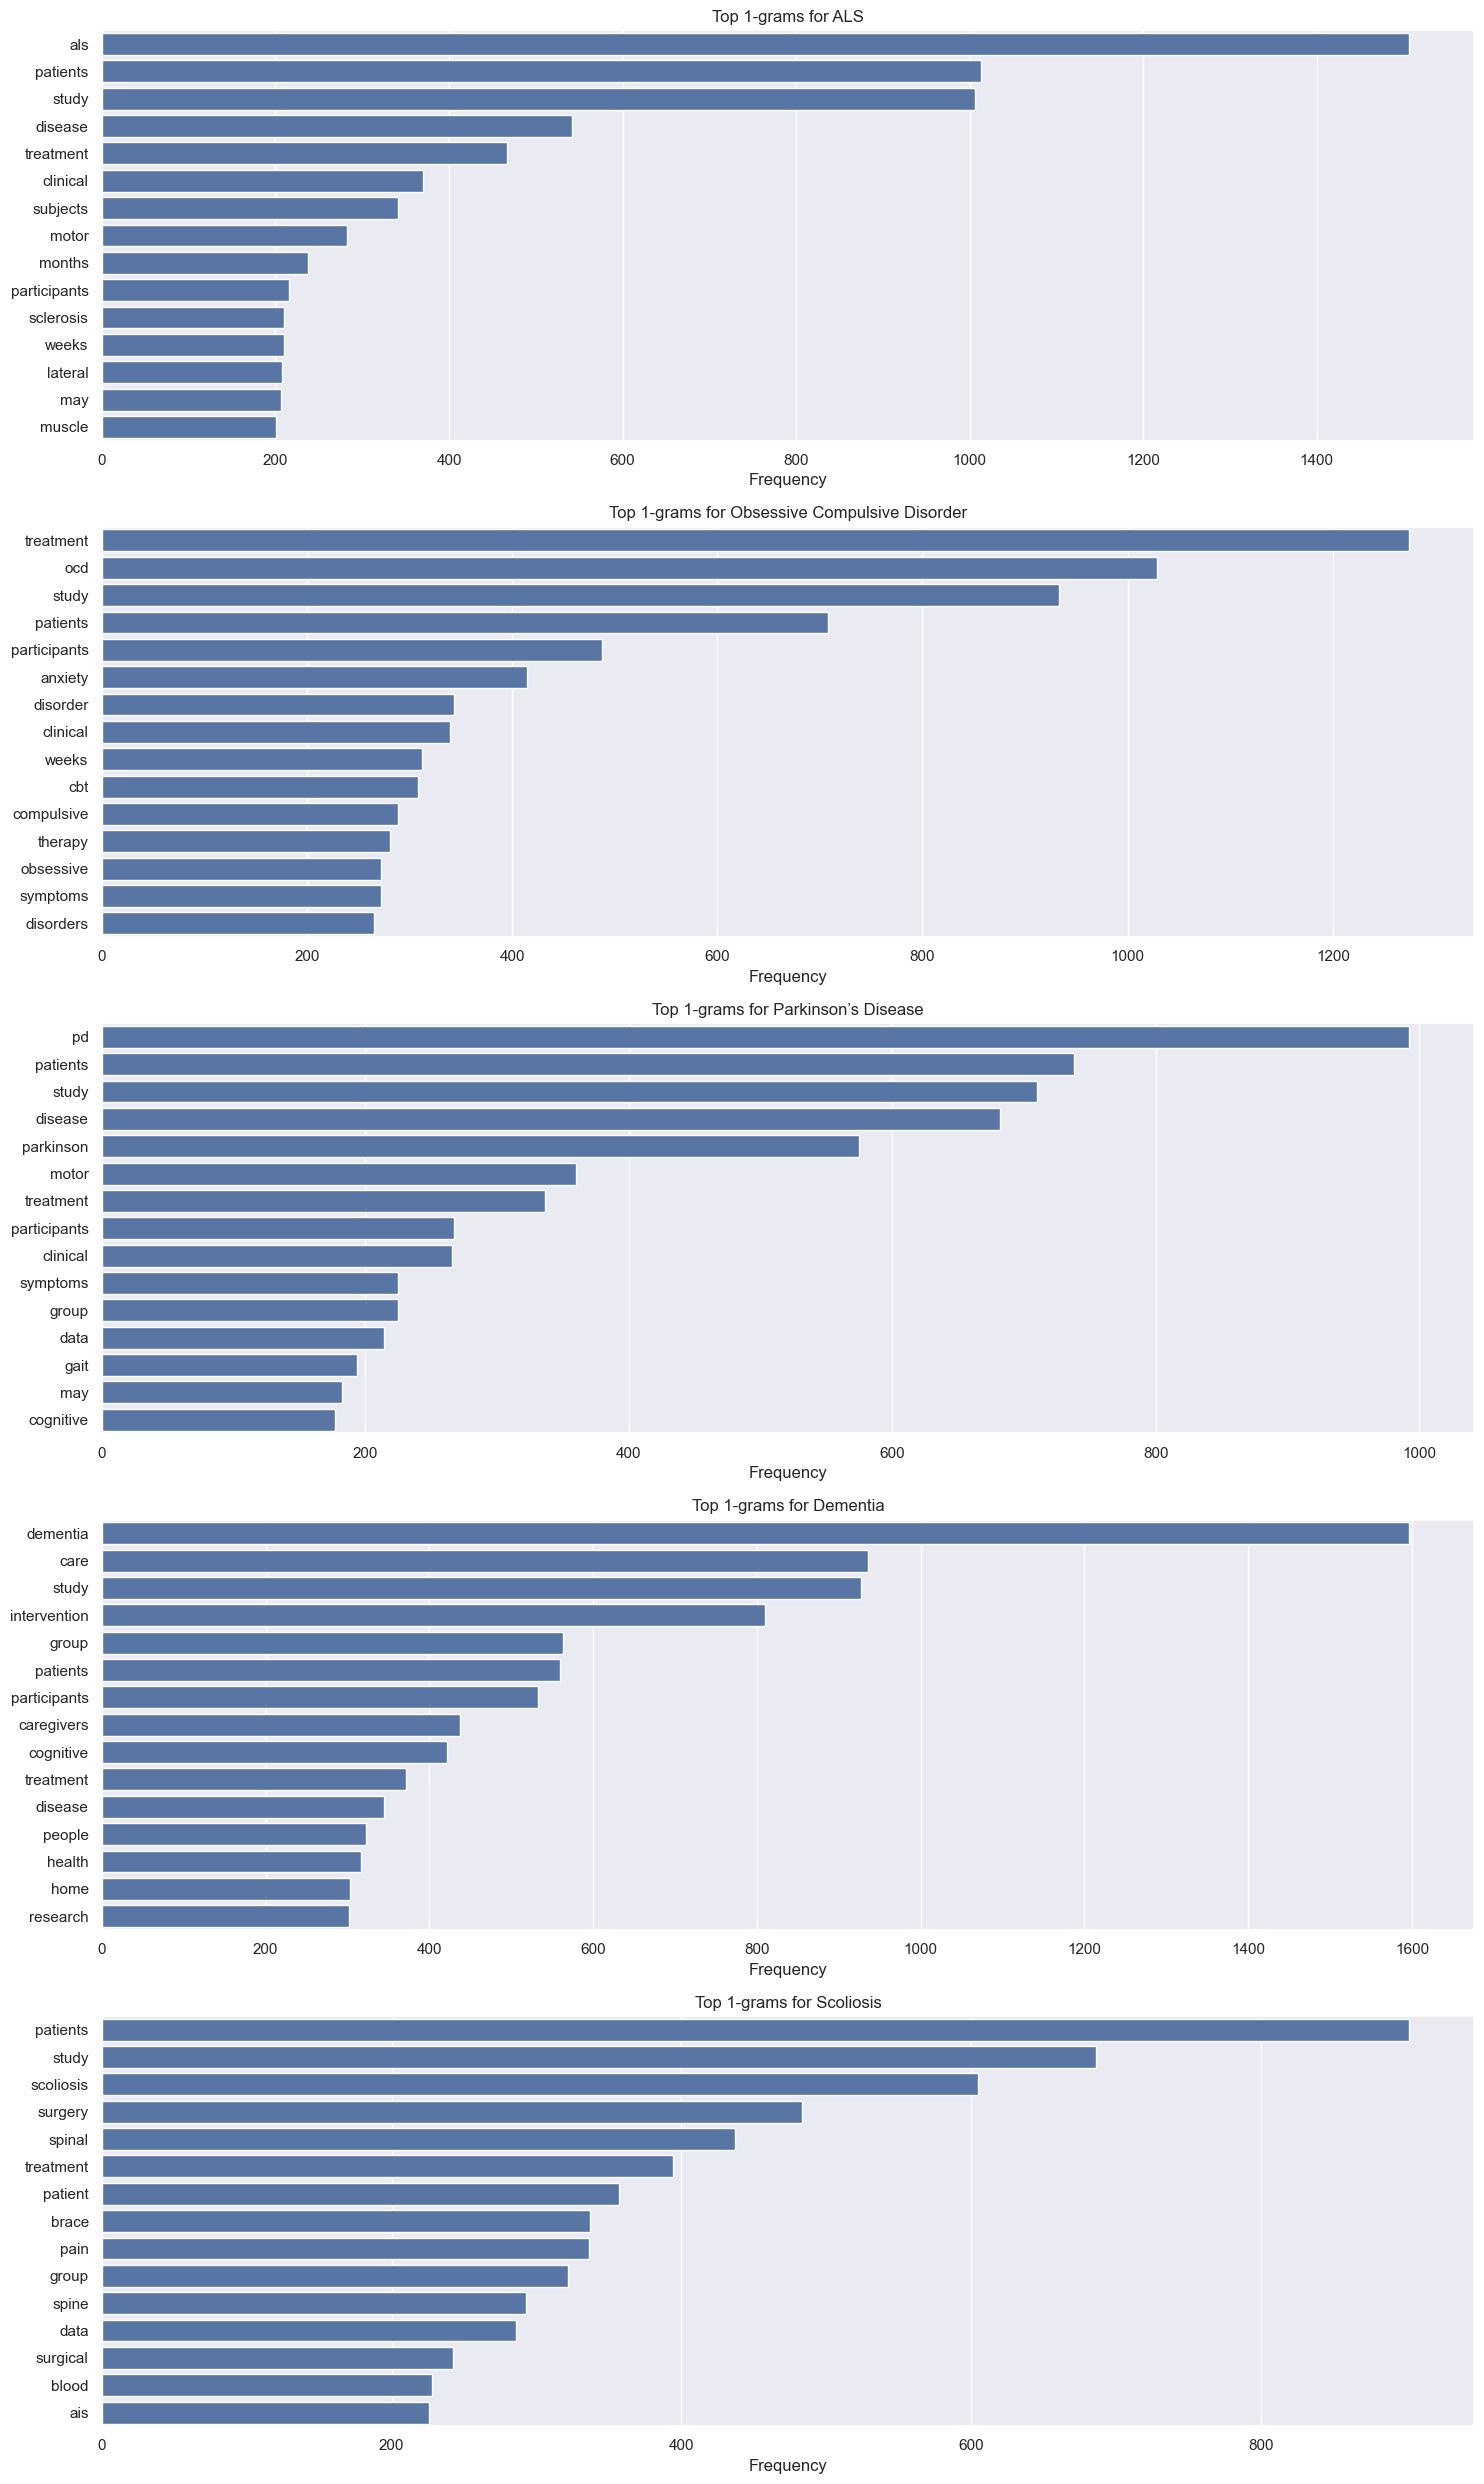

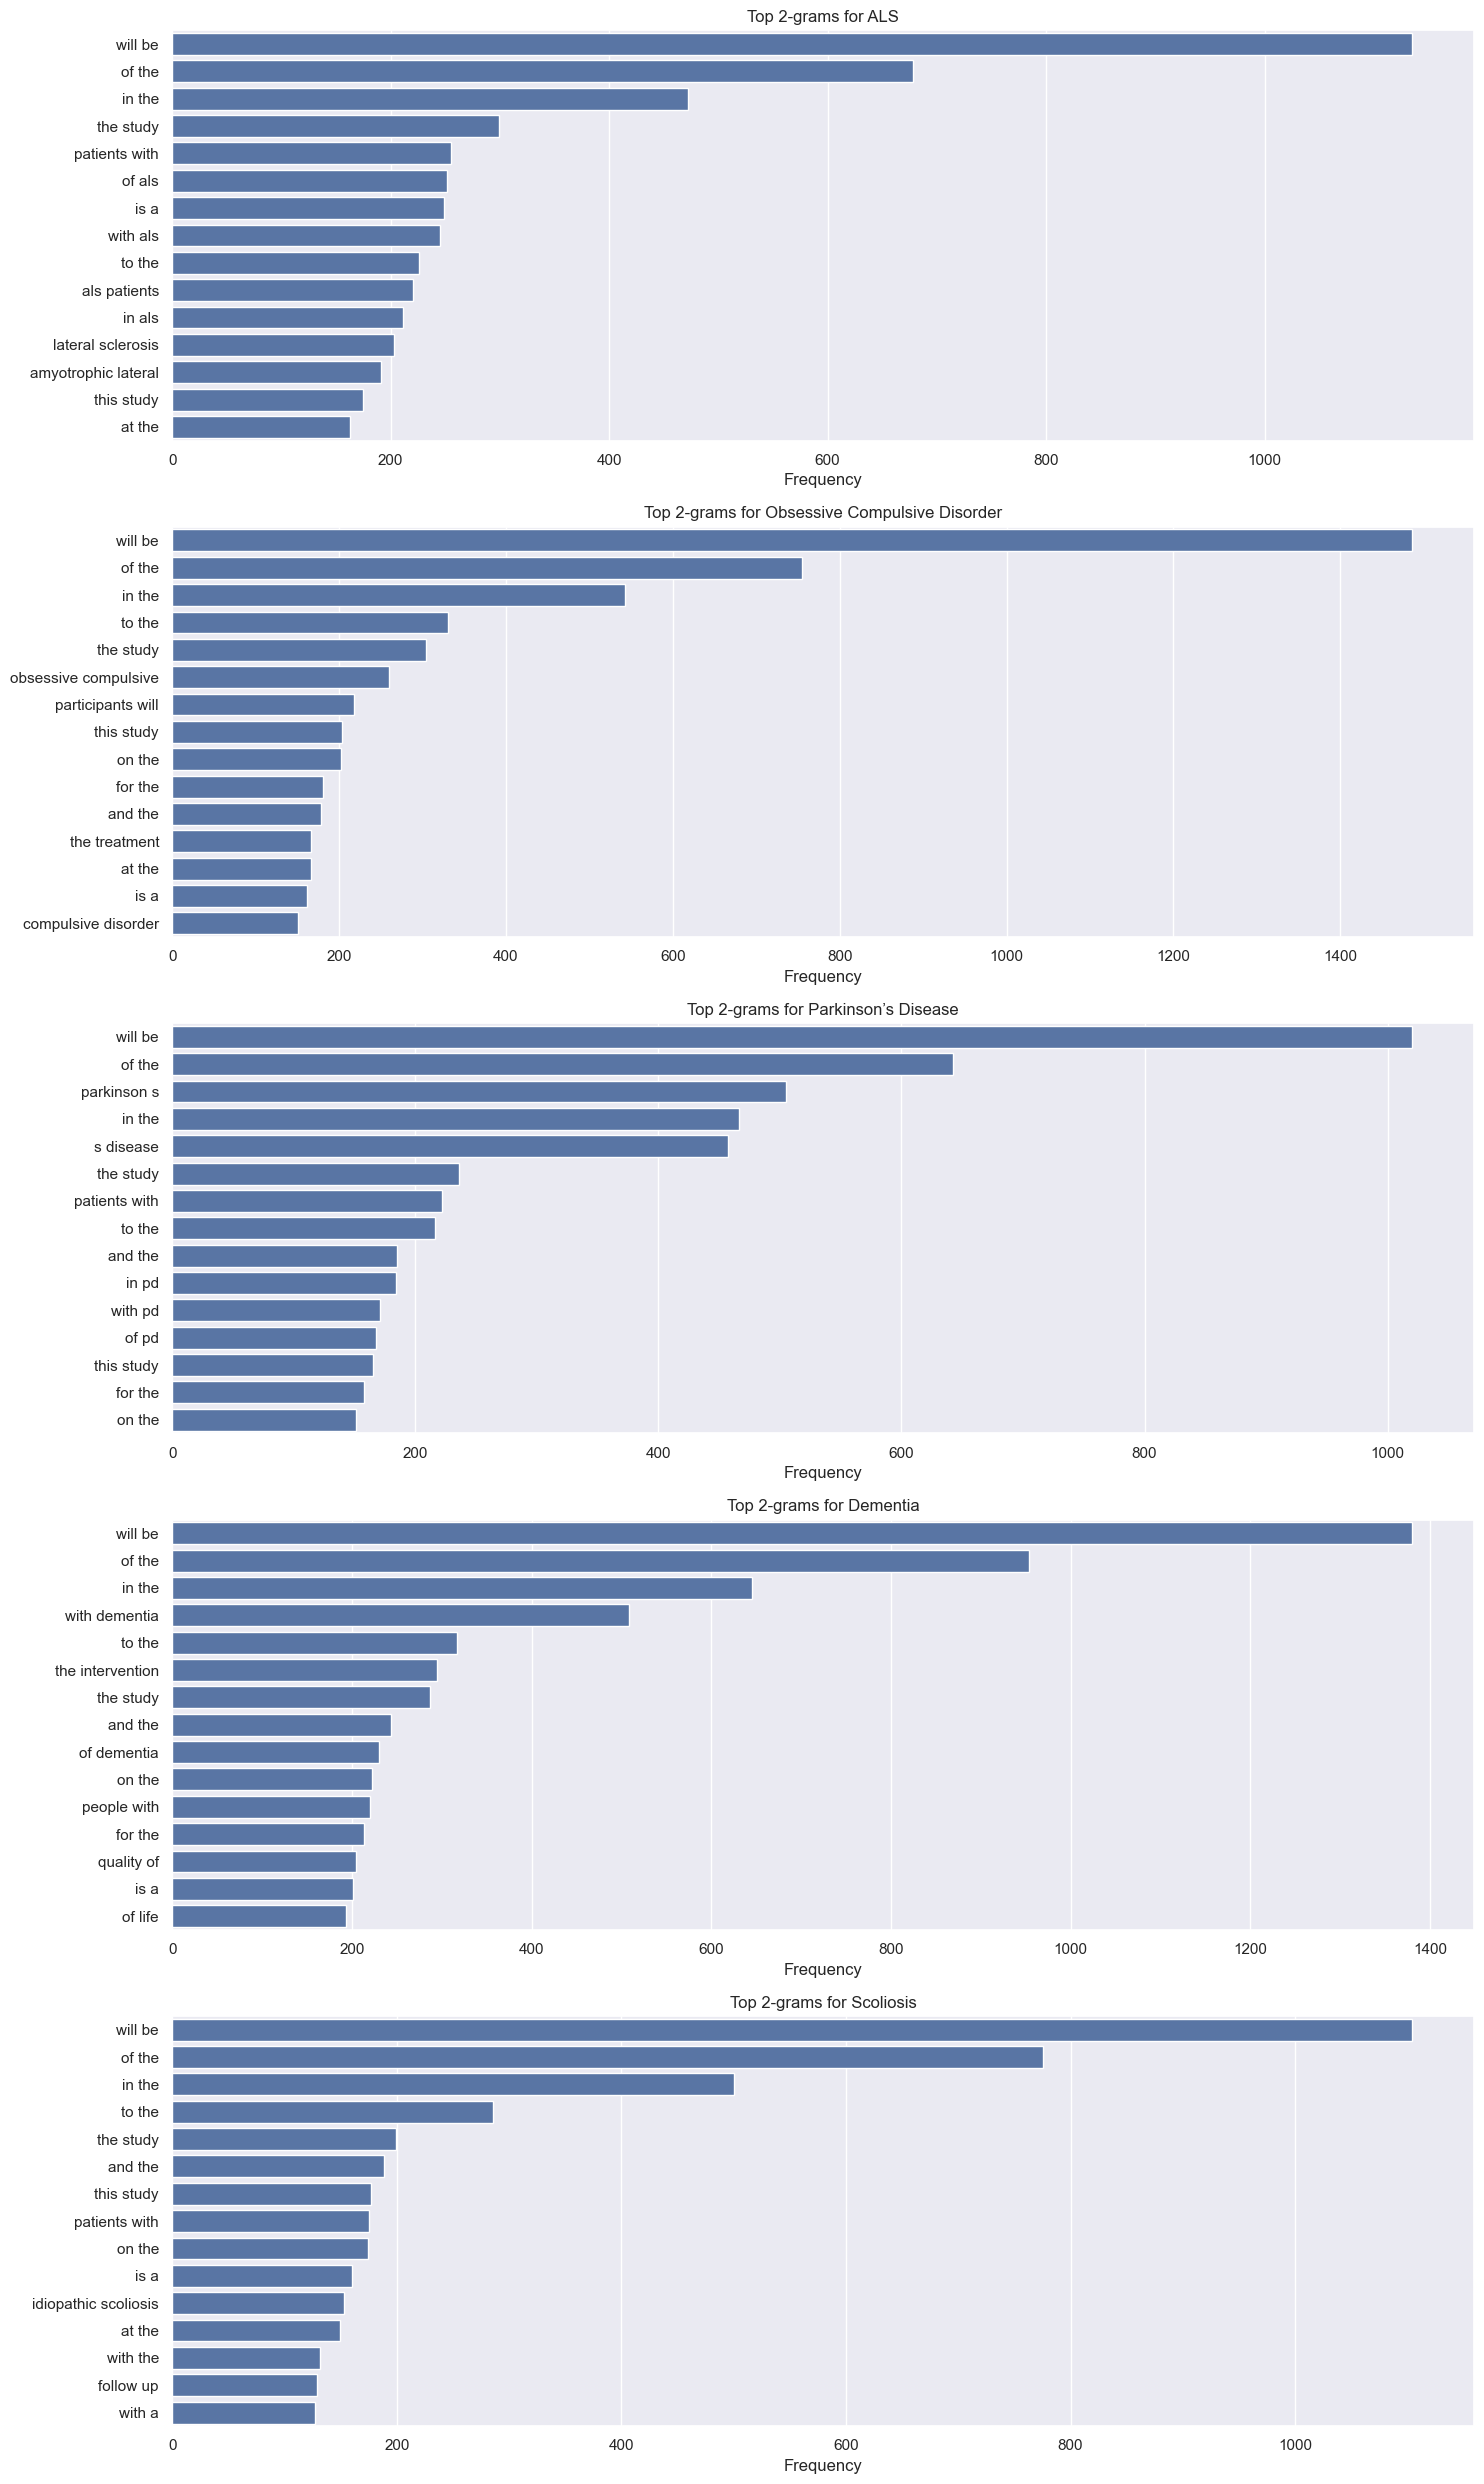

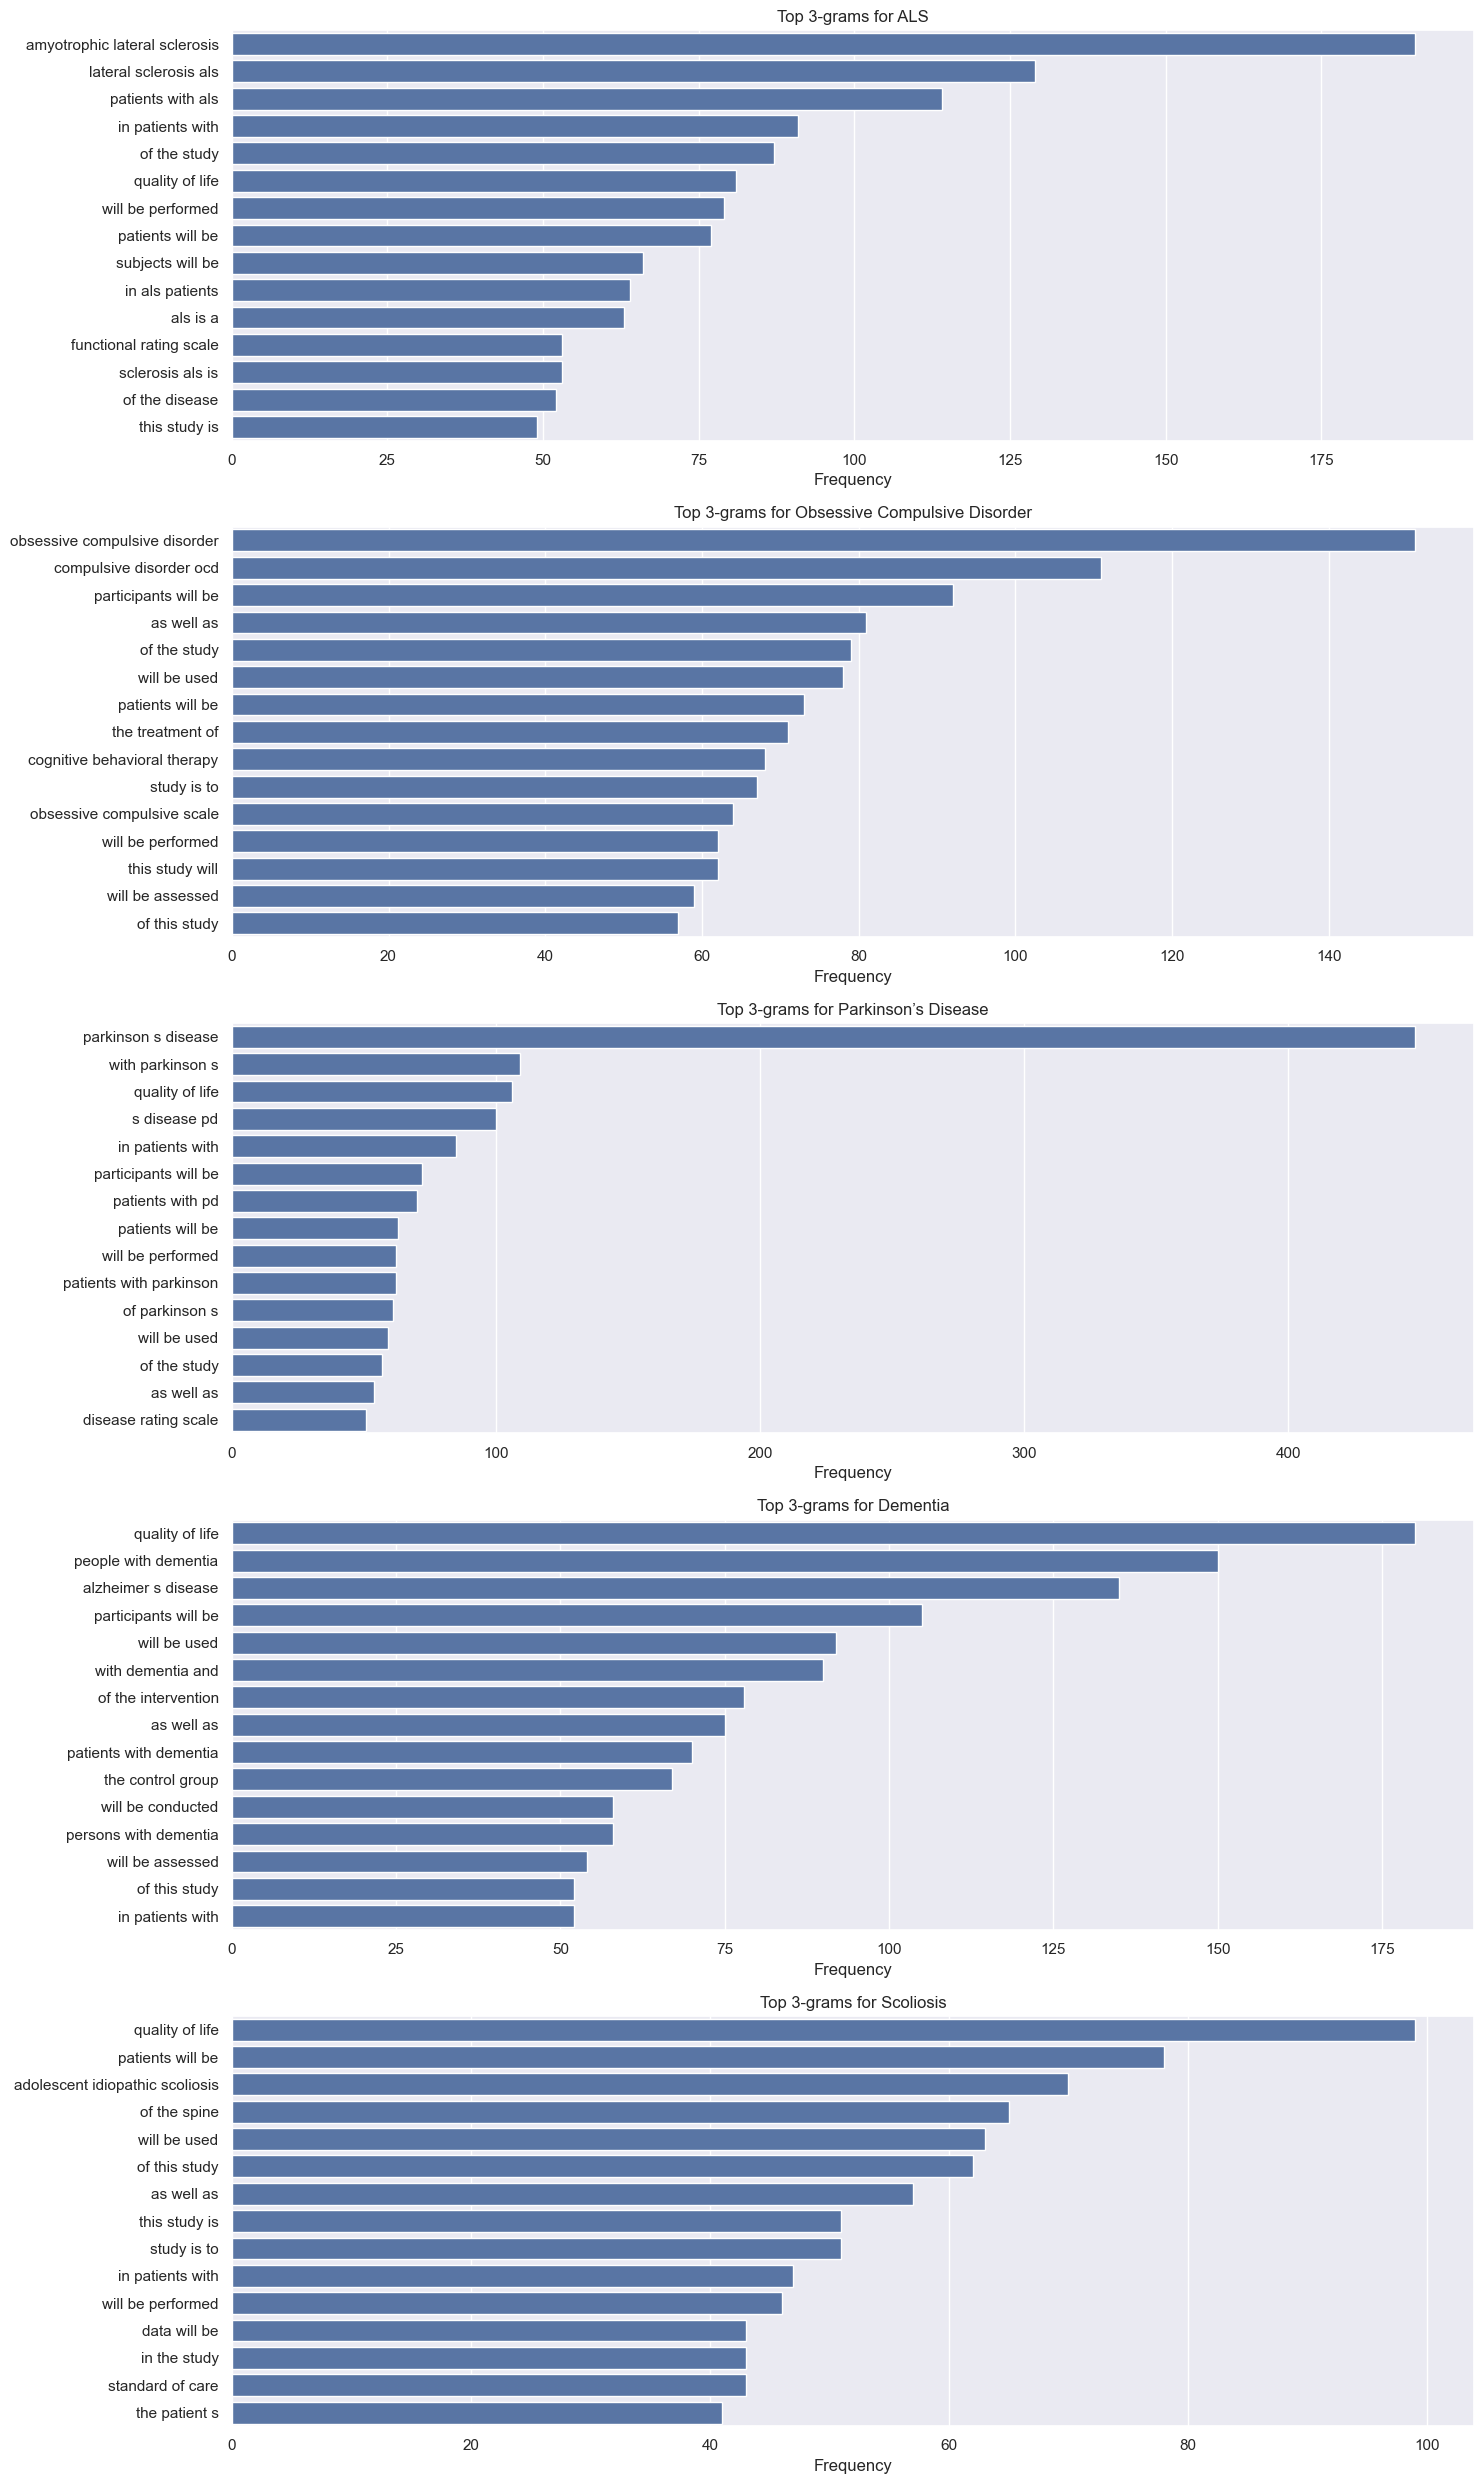

In [30]:
# Analyze n-grams
analysis = analyze_ngrams(df)

# Calculate distinctive n-grams
distinctive_grams = {
    n: calculate_distinctive_ngrams(analysis, n)
    for n in [1, 2, 3]
}

# Create visualizations
for n in [1, 2, 3]:
    plot_path = f'figures/ngrams_{n}.png'
    plot_ngram_distribution(analysis, n, save_path=plot_path)

# Print insights
print_ngram_insights(analysis, distinctive_grams)


The different medical conditions have characteristic language patterns. Reasons behind ALS development have always been 'amyotrophic lateral sclerosis' and multiple technical terms that pertain to nerve functions. The medical details about doctor assessment methods appear frequently in such posts.

The research on OCD centres on therapeutic approaches combined with research methodologies. Patients with obsessive compulsive disorder will see their condition specifically named multiple times in addition to various treatment-orientated terminology. Different behavioural treatment methods and research procedures are explained in these writings.

Paediatric Neurology forum members use PD as a short form, and they mostly talk about motor dysfunction symptoms. The progression timeline of symptoms merges with an analysis about their impact on physical motions.

Dementia-related content examines a wide scope of information using diverse terminology, which contains "dementia," "quality of life," "care," and "Alzheimer's." Bloggers discuss both psychological impacts of these conditions and methods to support those who care for patients mainly within these posts.

The discussions about scoliosis stand apart because they contain numerous spine-specific vocabulary and multiple references to surgical procedures. The content regarding surgical treatments and spinal curvature features significantly in most of these posts.

In developing our analysis tool, we should analyse words individually as well as in sequences of two and three elements (n-grammes) while tracking their appearance frequencies. When analysing the text, we need to protect medical terms from separation and maintain abbreviations because these medical indicators help identify which diseases are under consideration.